In [288]:
# Import libraries for HTTP requests, HTML parsing, and randomization
import requests  # For sending HTTP requests to fetch web pages
from bs4 import BeautifulSoup  # For parsing HTML content
import random  # For selecting random user agents

# Import libraries for data manipulation, regular expressions, and string handling
import pandas as pd  # For data manipulation and creating DataFrames
import re  # For regular expressions to clean text
from io import StringIO  # For reading HTML strings as file-like objects

# Import libraries for visualization, mapping, and geocoding
import folium  # For creating interactive maps
import seaborn as sns  # For statistical data visualization
import matplotlib.pyplot as plt  # For plotting graphs
from geopy.geocoders import Nominatim, Photon  # For geocoding locations
from geopy.extra.rate_limiter import RateLimiter  # For rate-limiting geocoding requests


In [289]:
# Define a list of user agents to rotate through, mimicking different browsers
user_agents = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Firefox/57.0',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Edge/16.16299',
]

In [290]:
# Define a function to randomly select a user agent from the list
def get_random_user_agent():
    """Return a random user-agent header for outgoing HTTP requests."""
    return random.choice(user_agents)

# Print an example of a selected user agent
print(f"Using User-Agent: {get_random_user_agent()}")

# Set the URL of the Wikipedia page to scrape
url = "https://en.wikipedia.org/wiki/List_of_Indian_states_and_union_territories_by_literacy_rate"

# Attempt to make an HTTP GET request to the URL
try:
    # Send the request with a random user agent and set a timeout
    response = requests.get(url, headers={"User-Agent": get_random_user_agent()}, timeout=30)
    # Raise an exception if the response status is not successful
    response.raise_for_status()
except requests.RequestException as exc:
    # Exit the program if there's a request error
    raise SystemExit(f"Request error: {exc}") from exc

# Print the HTTP status code and the size of the downloaded content
print(f"HTTP status: {response.status_code}")
print(f"Downloaded {len(response.content):,} bytes of HTML")

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

# Find all tables with the specific classes for collapsible sortable tables
Literacy_tables = soup.select("table.wikitable.sortable")

# Check if any tables were found, otherwise exit
if not Literacy_tables:
    raise SystemExit("No collapsible wikitable tables found. Check if the page layout has changed.")

# Print the number of candidate tables found
print(f"Found {len(Literacy_tables)} collapsible sortable tables on the page")

Using User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Firefox/57.0
HTTP status: 200
Downloaded 133,141 bytes of HTML
Found 3 collapsible sortable tables on the page


In [291]:
REQUIRED_COLUMNS = [
    "State/UT",
    "Literacy rate (2011 Census) (Total)",
    "Literacy rate (2011 Census) (Male)",
    "Literacy rate (2011 Census) (Female)",
    "Literacy rate (NSC survey 2017) (Total)",
    "Literacy rate (NSC survey 2017) (Male)",
    "Literacy rate (NSC survey 2017) (Female)",
    "Literacy rate (PLFS 2024) (Total)",
    "Literacy rate (PLFS 2024) (Male)",
    "Literacy rate (PLFS 2024) (Female)",
]

COLUMN_ALIASES = {
    "state ut": "State/UT",
    "state or union territory": "State/UT",
    "name": "State/UT",
    # Census 2011
    "census 2011 total": "Literacy rate (2011 Census) (Total)",
    "census 2011 male": "Literacy rate (2011 Census) (Male)",
    "census 2011 female": "Literacy rate (2011 Census) (Female)",
    # NSC Survey 2017
    "nsc survey 2017 total": "Literacy rate (NSC survey 2017) (Total)",
    "nsc survey 2017 male": "Literacy rate (NSC survey 2017) (Male)",
    "nsc survey 2017 female": "Literacy rate (NSC survey 2017) (Female)",
    # PLFS 2024
    "plfs report 2024 total": "Literacy rate (PLFS 2024) (Total)",
    "plfs report 2024 male": "Literacy rate (PLFS 2024) (Male)",
    "plfs report 2024 female": "Literacy rate (PLFS 2024) (Female)",
}

CITATION_PATTERN = re.compile(r"\[[^\]]+\]")
WHITESPACE_PATTERN = re.compile(r"\s+")

def clean_string(value):
    if pd.isna(value):
        return ""
    text = str(value)
    text = CITATION_PATTERN.sub("", text)
    text = text.replace("\xa0", " ").strip()
    return WHITESPACE_PATTERN.sub(" ", text)

def standardise_column(label):
    if isinstance(label, tuple):
        label = " ".join(str(part) for part in label if part and not pd.isna(part))
    cleaned = clean_string(label)
    slug = re.sub(r"[^a-z0-9]+", " ", cleaned.lower()).strip()
    if slug in COLUMN_ALIASES:
        return COLUMN_ALIASES[slug]
    if "2011" in slug:
        if "male" in slug: return "Literacy rate (2011 Census) (Male)"
        elif "female" in slug: return "Literacy rate (2011 Census) (Female)"
        else: return "Literacy rate (2011 Census) (Total)"
    elif "2017" in slug or "nsc" in slug:
        if "male" in slug: return "Literacy rate (NSC survey 2017) (Male)"
        elif "female" in slug: return "Literacy rate (NSC survey 2017) (Female)"
        else: return "Literacy rate (NSC survey 2017) (Total)"
    elif "2024" in slug or "plfs" in slug:
        if "male" in slug: return "Literacy rate (PLFS 2024) (Male)"
        elif "female" in slug: return "Literacy rate (PLFS 2024) (Female)"
        else: return "Literacy rate (PLFS 2024) (Total)"
    elif "state" in slug or "union territory" in slug or "ut" in slug:
        return "State/UT"
    return cleaned

# Fetch page
try:
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}, timeout=30)
    response.raise_for_status()
except requests.RequestException as exc:
    raise SystemExit(f"Request error: {exc}")

soup = BeautifulSoup(response.content, "html.parser")

# Find all relevant tables (collapsible, sortable)
tables = soup.select("table.wikitable.sortable")
if not tables:
    # fallback to normal wikitable
    tables = soup.find_all("table", {"class": "wikitable"})
if not tables:
    raise SystemExit("No wikitable tables found. Check if the page layout has changed.")

tables_dfs = []
for tbl in tables:
    parsed = pd.read_html(StringIO(str(tbl)), flavor="bs4")
    if not parsed:
        continue
    df = parsed[0]
    df.columns = [standardise_column(c) for c in df.columns]
    df = df.loc[:, ~df.columns.duplicated()]
    if "State/UT" not in df.columns:
        continue
    df = df.applymap(clean_string)
    df = df[df["State/UT"].str.lower() != "state/ut"]  # remove header rows inside table
    if df.empty:
        continue
    tables_dfs.append(df)

if not tables_dfs:
    raise SystemExit("No valid tables parsed.")

# Identify which dataset is which
census_df = None
nsc_df = None
plfs_df = None
for df in tables_dfs:
    cols_lower = " ".join(df.columns).lower()
    if "2011 census" in cols_lower or "2011" in cols_lower:
        census_df = df
    elif "nsc survey 2017" in cols_lower or "2017" in cols_lower:
        nsc_df = df
    elif "plfs 2024" in cols_lower or "2024" in cols_lower:
        plfs_df = df

# Merge horizontally
final_df = census_df.copy()
for extra in [nsc_df, plfs_df]:
    if extra is not None:
        _df = final_df.merge(extra, on="State/UT", how="outer", suffixes=("", "_dup"))

# Drop any duplicate columns created by merge
final_df = final_df.loc[:, ~final_df.columns.str.endswith("_dup")]

# Ensure all required columns
for col in REQUIRED_COLUMNS:
    if col not in final_df.columns:
        final_df[col] = "Unknown"

final_df = final_df[REQUIRED_COLUMNS]

# Remove summary rows like "India"
final_df = final_df[final_df["State/UT"].str.lower() != "india"]

# Save to CSV
final_df.to_csv("Literacy_Rate.csv", index=False, encoding="utf‑8")
print(f"✅ Saved Literacy_Rate.csv with {len(final_df)} unique rows")
print(final_df.head())


✅ Saved Literacy_Rate.csv with 38 unique rows
                      State/UT Literacy rate (2011 Census) (Total)  \
1  Andaman and Nicobar Islands                               86.63   
2               Andhra Pradesh                               67.02   
3            Arunachal Pradesh                               65.38   
4                        Assam                               72.19   
5                        Bihar                               61.80   

  Literacy rate (2011 Census) (Male) Literacy rate (2011 Census) (Female)  \
1                              90.27                                82.43   
2                              74.88                                59.15   
3                              72.55                                57.70   
4                              77.85                                66.27   
5                              71.20                                51.50   

  Literacy rate (NSC survey 2017) (Total)  \
1                        

/var/folders/yg/622xcjgj4gjf30pqs2x_8xl40000gp/T/ipykernel_3354/3099733722.py:93: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(clean_string)


In [292]:
# --- PART 2: Census/Population Table Extraction ---

population_tables = soup.find_all("table", {"class": "wikitable"})
population_df = None
for tbl in population_tables:
    parsed = pd.read_html(StringIO(str(tbl)), flavor="bs4")
    if not parsed:
        continue
    df = parsed[0]
    heading = tbl.find_previous("h2") or tbl.find_previous("h3")
    title = heading.get_text(strip=True).lower() if heading else ""
    if "census" in title or "population" in title:
        population_df = df
        break

if population_df is not None:
    population_df = population_df.loc[:, ~population_df.columns.str.contains("remarks", case=False)]
    population_df = population_df.applymap(lambda x: str(x).replace("\xa0", " ").replace("\n", " ").strip())
    population_df.to_csv("Literacy_rate_population.csv", index=False, encoding="utf-8")
    print(f"✅ Saved Literacy_rate_population.csv with {len(population_df)} rows and {len(population_df.columns)} columns.")
else:
    print("⚠️ No Census/Population table found on the page.")

✅ Saved Literacy_rate_population.csv with 36 rows and 8 columns.


/var/folders/yg/622xcjgj4gjf30pqs2x_8xl40000gp/T/ipykernel_3354/347629959.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  population_df = population_df.applymap(lambda x: str(x).replace("\xa0", " ").replace("\n", " ").strip())


/var/folders/yg/622xcjgj4gjf30pqs2x_8xl40000gp/T/ipykernel_3354/2348660123.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pop_col, y="State/UT", data=top10, palette="Blues_r")
/Users/yaaminisree/Web_Scraping_Data_Processing/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


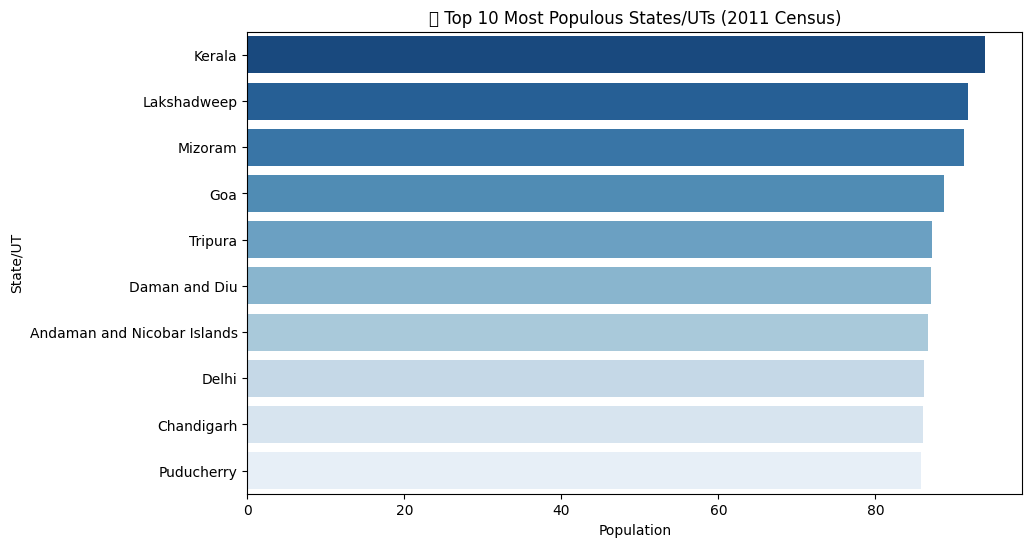

/Users/yaaminisree/Web_Scraping_Data_Processing/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


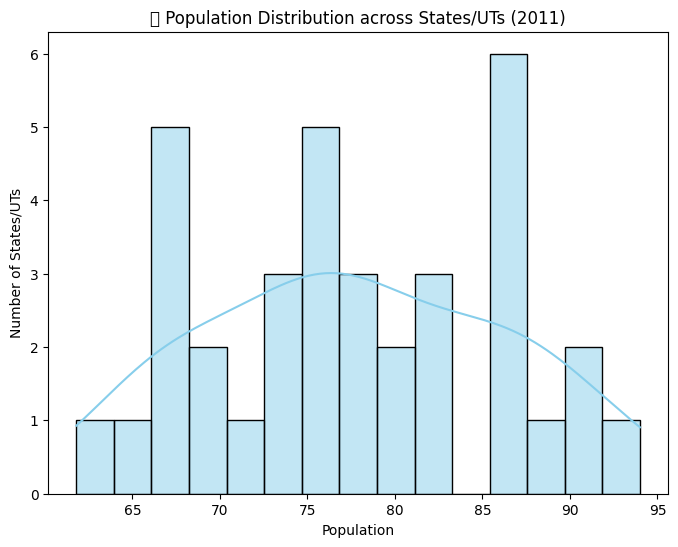

/Users/yaaminisree/Web_Scraping_Data_Processing/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


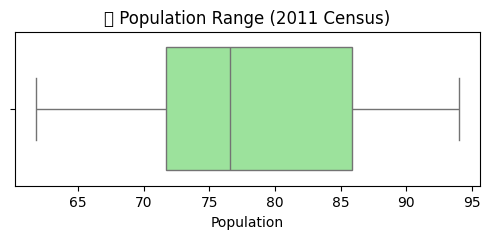

/var/folders/yg/622xcjgj4gjf30pqs2x_8xl40000gp/T/ipykernel_3354/2348660123.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Population_Bin", data=population_df, palette="viridis")
/Users/yaaminisree/Web_Scraping_Data_Processing/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


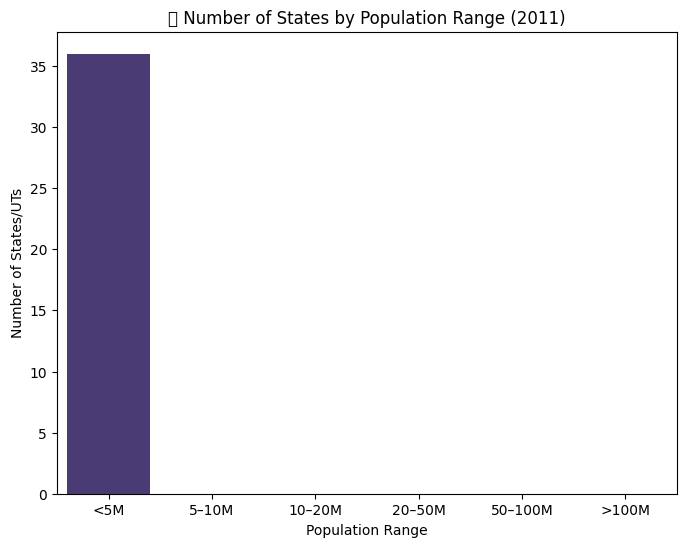

/Users/yaaminisree/Web_Scraping_Data_Processing/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


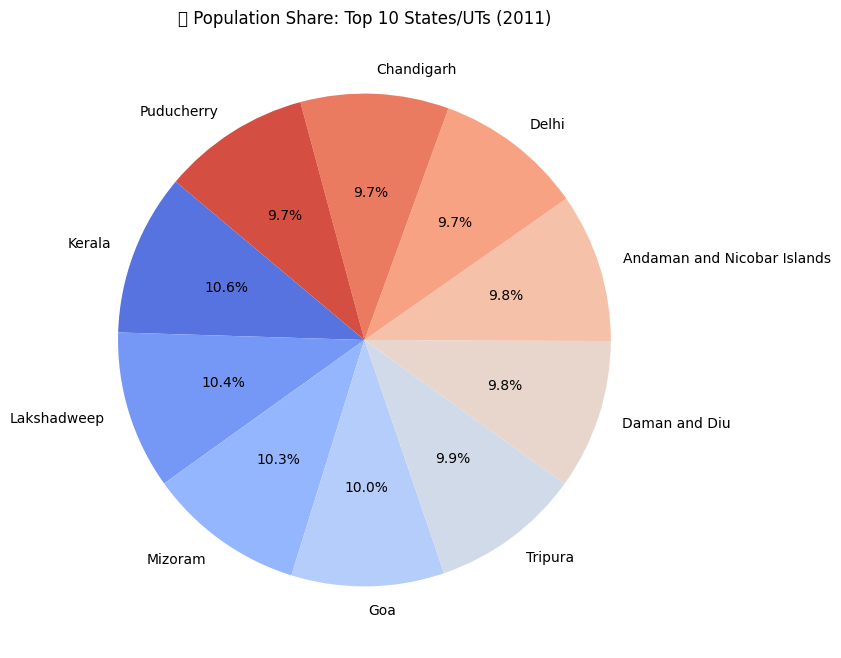

In [293]:

# --- Use 2011 Census column as population ---
pop_col = '2011'

# Convert population column to numeric
population_df[pop_col] = (
    population_df[pop_col]
    .astype(str)
    .str.replace(",", "")
    .str.extract(r"(\d+\.?\d*)")[0]
    .astype(float)
)

# Clean State/UT column
if "State/UT" not in population_df.columns:
    population_df.rename(columns={population_df.columns[0]: "State/UT"}, inplace=True)

# --- KPI 1: Top 10 Most Populous States ---
top10 = population_df.nlargest(10, pop_col)
plt.figure(figsize=(10, 6))
sns.barplot(x=pop_col, y="State/UT", data=top10, palette="Blues_r")
plt.title("🏙️ Top 10 Most Populous States/UTs (2011 Census)")
plt.xlabel("Population")
plt.ylabel("State/UT")
plt.show()

# --- KPI 2: Population Distribution ---
plt.figure(figsize=(8, 6))
sns.histplot(population_df[pop_col], bins=15, kde=True, color="skyblue")
plt.title("📊 Population Distribution across States/UTs (2011)")
plt.xlabel("Population")
plt.ylabel("Number of States/UTs")
plt.show()

# --- KPI 3: Population Range (Boxplot) ---
plt.figure(figsize=(6, 2))
sns.boxplot(x=population_df[pop_col], color="lightgreen")
plt.title("📏 Population Range (2011 Census)")
plt.xlabel("Population")
plt.show()

# --- KPI 4: Population Categories ---
bins = [0, 5_000_000, 10_000_000, 20_000_000, 50_000_000, 100_000_000, 200_000_000]
labels = ["<5M", "5–10M", "10–20M", "20–50M", "50–100M", ">100M"]
population_df["Population_Bin"] = pd.cut(population_df[pop_col], bins=bins, labels=labels)
plt.figure(figsize=(8, 6))
sns.countplot(x="Population_Bin", data=population_df, palette="viridis")
plt.title("📈 Number of States by Population Range (2011)")
plt.xlabel("Population Range")
plt.ylabel("Number of States/UTs")
plt.show()

# --- KPI 5: Population Share Pie Chart ---
top10 = population_df.nlargest(10, pop_col)
plt.figure(figsize=(8, 8))
plt.pie(
    top10[pop_col],
    labels=top10["State/UT"],
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("coolwarm", 10),
)
plt.title("🧩 Population Share: Top 10 States/UTs (2011)")
plt.show()


/var/folders/yg/622xcjgj4gjf30pqs2x_8xl40000gp/T/ipykernel_3354/181099638.py:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/yaaminisree/Web_Scraping_Data_Processing/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


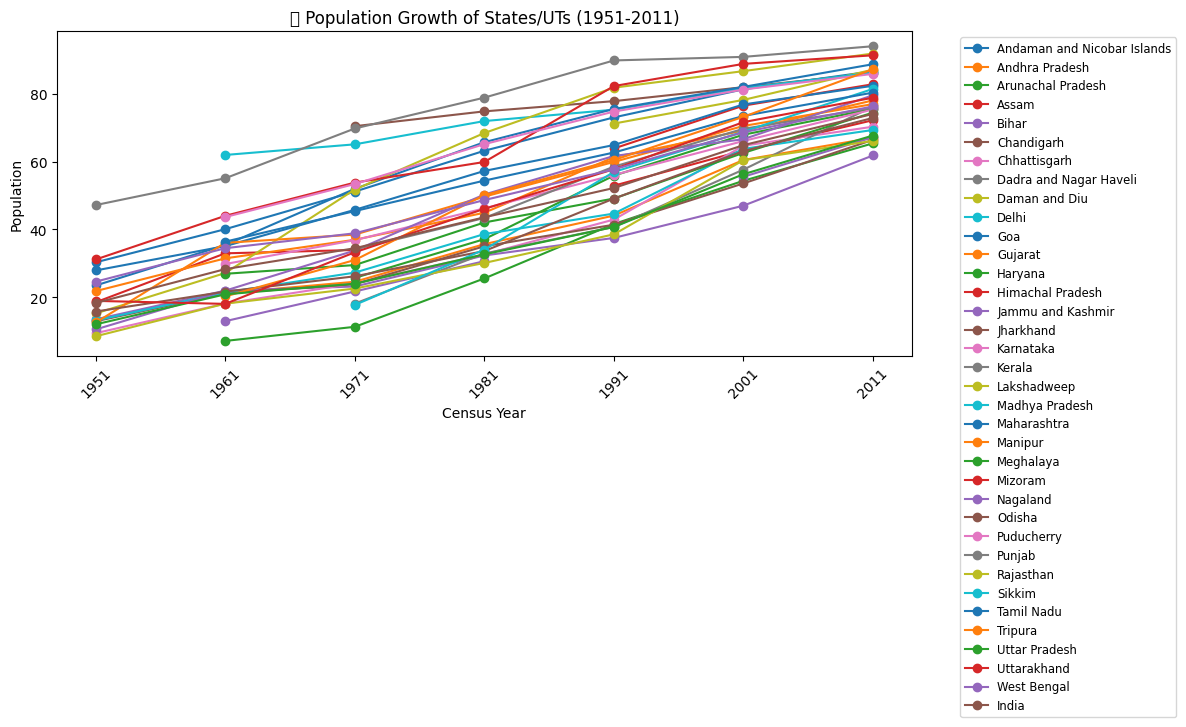

In [294]:

# --- Setup ---
# List of census years
decades = ['1951', '1961', '1971', '1981', '1991', '2001', '2011']

# Convert all decade columns to numeric
for col in decades:
    population_df[col] = (
        population_df[col]
        .astype(str)
        .str.replace(",", "")
        .str.extract(r"(\d+\.?\d*)")[0]
        .astype(float)
    )

# Ensure State/UT column exists
if "State/UT" not in population_df.columns:
    population_df.rename(columns={population_df.columns[0]: "State/UT"}, inplace=True)

# --- KPI 2: Population Growth Over Decades ---
plt.figure(figsize=(12, 6))
for idx, row in population_df.iterrows():
    plt.plot(decades, row[decades], marker='o', label=row["State/UT"])
plt.xticks(rotation=45)
plt.ylabel("Population")
plt.xlabel("Census Year")
plt.title("📈 Population Growth of States/UTs (1951-2011)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


/var/folders/yg/622xcjgj4gjf30pqs2x_8xl40000gp/T/ipykernel_3354/188598125.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='2011', y='State/UT', data=top5_2011, palette="Blues_r")
/Users/yaaminisree/Web_Scraping_Data_Processing/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


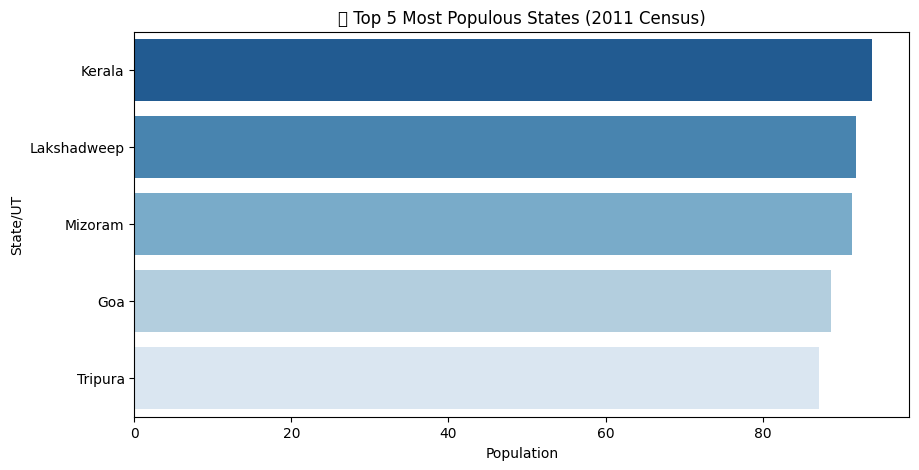

/var/folders/yg/622xcjgj4gjf30pqs2x_8xl40000gp/T/ipykernel_3354/188598125.py:37: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/yaaminisree/Web_Scraping_Data_Processing/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


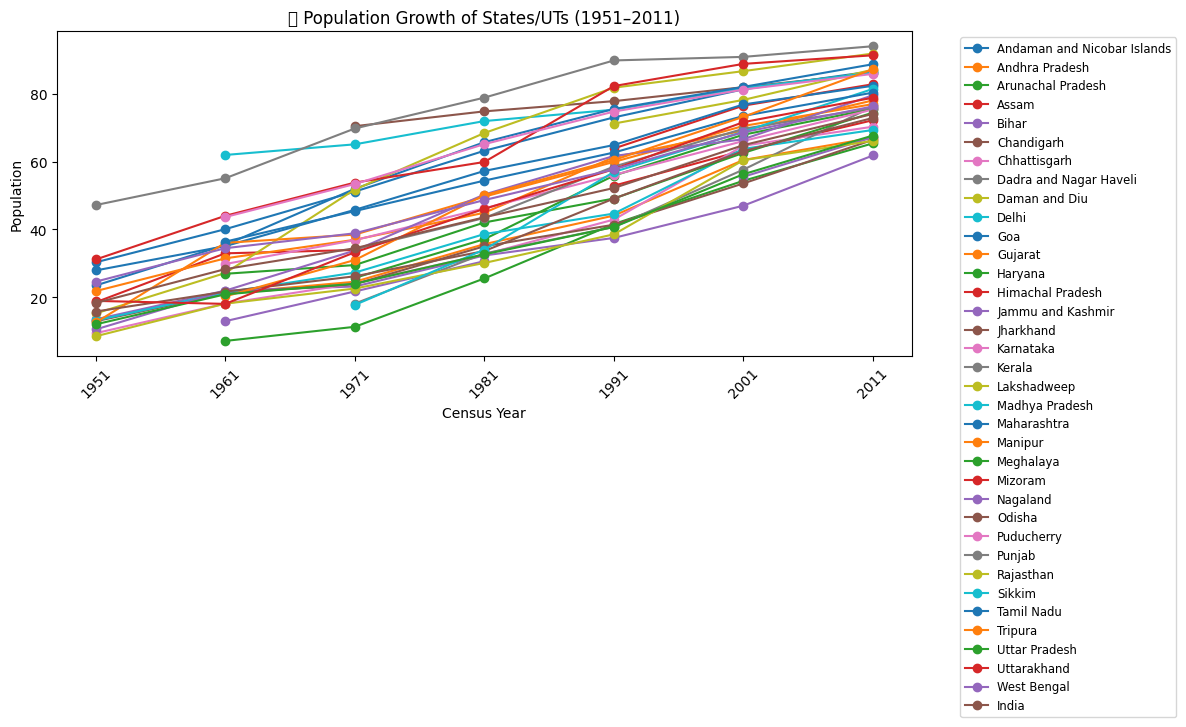

/Users/yaaminisree/Web_Scraping_Data_Processing/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


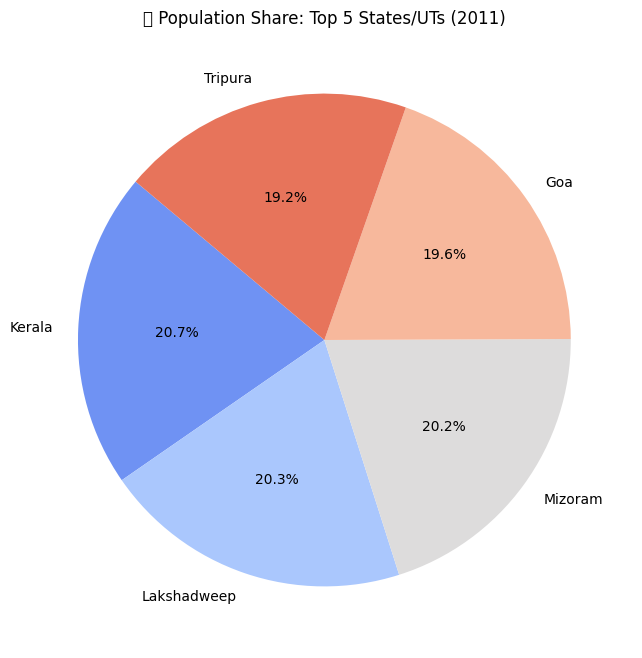

In [295]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Ensure population columns are numeric ---
decades = ['1951', '1961', '1971', '1981', '1991', '2001', '2011']
for col in decades:
    population_df[col] = (
        population_df[col].astype(str)
        .str.replace(",", "")
        .str.extract(r"(\d+\.?\d*)")[0]
        .astype(float)
    )

# Ensure State/UT column exists
if "State/UT" not in population_df.columns:
    population_df.rename(columns={population_df.columns[0]: "State/UT"}, inplace=True)

# --- KPI 1: Top 5 Most Populous States (2011 Census) ---
top5_2011 = population_df.nlargest(5, '2011')
plt.figure(figsize=(10, 5))
sns.barplot(x='2011', y='State/UT', data=top5_2011, palette="Blues_r")
plt.title("🏙️ Top 5 Most Populous States (2011 Census)")
plt.xlabel("Population")
plt.ylabel("State/UT")
plt.show()

# --- KPI 2: Population Growth Over Decades ---
plt.figure(figsize=(12, 6))
for idx, row in population_df.iterrows():
    plt.plot(decades, row[decades], marker='o', label=row['State/UT'])
plt.xticks(rotation=45)
plt.ylabel("Population")
plt.xlabel("Census Year")
plt.title("📈 Population Growth of States/UTs (1951–2011)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

# --- KPI 5: Top 5 States Population Share (2011) ---
plt.figure(figsize=(8, 8))
plt.pie(
    top5_2011['2011'],
    labels=top5_2011['State/UT'],
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("coolwarm", 5),
)
plt.title("🧩 Population Share: Top 5 States/UTs (2011)")
plt.show()


# 📊 India Population Map (1951–2011)

This interactive map visualizes the **population growth of Indian States/UTs** across seven census decades (1951–2011). Each state is color-coded based on population ranges and displays the exact population in a tooltip.

---

## Features

- **Decade Layers:** Switch between 1951, 1961, 1971, 1981, 1991, 2001, and 2011 using the layer control.
- **Tooltips:** Hover over any state to see the state name and exact population for the selected decade.
- **Color Coding:**  
  - Very Low: `#cce6ff`  
  - Low: `#99ccff`  
  - Medium: `#66b3ff`  
  - High: `#3399ff`  
  - Very High: `#0066cc`  
  - Missing: `grey (#d3d3d3)`
- **Interactive Zoom & Pan:** Navigate to any state easily.
- **Legend:** Shows the population ranges by color.

In [296]:
# --- STEP 1: Ensure population_df is cleaned & numeric ---
decades = ['1951', '1961', '1971', '1981', '1991', '2001', '2011']

# Convert all decade columns to numeric
for col in decades:
    population_df[col] = (
        population_df[col]
        .astype(str)
        .str.replace(",", "")
        .str.extract(r"(\d+\.?\d*)")[0]
        .astype(float)
    )

# Ensure State/UT column exists
if "State/UT" not in population_df.columns:
    population_df.rename(columns={population_df.columns[0]: "State/UT"}, inplace=True)

# --- STEP 2: Load India GeoJSON ---
geojson_url = "https://raw.githubusercontent.com/udit-001/india-maps-data/main/geojson/india.geojson"
india_geo = requests.get(geojson_url).json()

# --- STEP 3: Merge population data into GeoJSON ---
for feature in india_geo["features"]:
    state_name = feature["properties"]["st_nm"].strip()
    row = population_df[population_df["State/UT"].str.lower() == state_name.lower()]
    for decade in decades:
        feature["properties"][f"pop_{decade}"] = row[decade].values[0] if not row.empty else None

# --- STEP 4: Color function (High-contrast Blue) ---
def get_color(pop, vmin, vmax):
    """
    Assigns distinct blue shades based on population quintiles for visibility.
    """
    if pd.isna(pop):
        return "#d3d3d3"  # grey for missing
    
    # Define quintiles
    thresholds = np.linspace(vmin, vmax, 6)  # 5 ranges
    # Blue palette from light to dark
    palette = ["#cce6ff", "#99ccff", "#66b3ff", "#3399ff", "#0066cc"]
    
    for i in range(5):
        if pop <= thresholds[i+1]:
            return palette[i]
    return palette[-1]  # max value

# --- STEP 5: Create Folium layer for a decade ---
def create_population_layer(decade):
    pops = [f["properties"][f"pop_{decade}"] for f in india_geo["features"] if f["properties"][f"pop_{decade}"] is not None]
    vmin, vmax = min(pops), max(pops)

    def style_function(feature):
        pop = feature["properties"].get(f"pop_{decade}")
        return {
            "fillColor": get_color(pop, vmin, vmax),
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.8
        }

    tooltip_fields = ["st_nm", f"pop_{decade}"]
    tooltip_aliases = ["State:", f"Population ({decade}):"]

    return folium.GeoJson(
        india_geo,
        style_function=style_function,
        name=f"{decade}",
        tooltip=folium.GeoJsonTooltip(
            fields=tooltip_fields,
            aliases=tooltip_aliases,
            localize=True,
            sticky=True,
            labels=True,
            fmt="{:,}"  # format with commas
        )
    )

# --- STEP 6: Create Folium map ---
m = folium.Map(location=[22.97, 78.65], zoom_start=5, tiles="cartodb positron")

# Add layers for all decades
for decade in decades:
    create_population_layer(decade).add_to(m)

# --- STEP 7: Add Layer Control ---
folium.LayerControl(collapsed=False).add_to(m)

# --- STEP 8: Add Legend ---
legend_html = """
<div style="position: fixed; bottom: 50px; left: 50px; width: 220px;
     background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
     padding: 10px; border-radius:10px;">
<b>📊 Population (States/UTs)</b><br>
<svg width="20" height="20"><rect width="20" height="20" style="fill:#cce6ff"/></svg> Very Low<br>
<svg width="20" height="20"><rect width="20" height="20" style="fill:#99ccff"/></svg> Low<br>
<svg width="20" height="20"><rect width="20" height="20" style="fill:#66b3ff"/></svg> Medium<br>
<svg width="20" height="20"><rect width="20" height="20" style="fill:#3399ff"/></svg> High<br>
<svg width="20" height="20"><rect width="20" height="20" style="fill:#0066cc"/></svg> Very High<br>
Grey: Missing
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# --- STEP 9: Save map ---
m.save("India_Population_Map_Blue_Tooltip.html")
print("✅ Map saved as 'India_Population_Map_Blue_Tooltip.html'")


✅ Map saved as 'India_Population_Map_Blue_Tooltip.html'


In [297]:

# --- Load literacy data ---
df = pd.read_csv("Literacy_Rate.csv")

# Columns and years to generate maps
years = {
    "2011 Census": "Literacy rate (2011 Census) (Total)",
    "2017 NSC": "Literacy rate (NSC survey 2017) (Total)",
    "2024 PLFS": "Literacy rate (PLFS 2024) (Total)"
}

# Clean and convert literacy rates to numeric
for col in years.values():
    df[col] = (
        df[col].astype(str)
        .str.replace("%", "", regex=False)
        .replace("Unknown", pd.NA)
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

# --- Load India states GeoJSON ---
with open("india_states.geojson", "r", encoding="utf-8") as f:
    india_geo = json.load(f)

# Detect key used for state names
geo_keys = list(india_geo["features"][0]["properties"].keys())
state_key = geo_keys[0]  # adjust if needed (print(geo_keys) if unsure)

# Align state names
state_name_map = {
    "Andaman & Nicobar Islands": "Andaman and Nicobar",
    "NCT of Delhi": "Delhi",
    "Odisha": "Orissa",
    "Puducherry": "Pondicherry",
}
df["State/UT"] = df["State/UT"].replace(state_name_map)

# --- Color function ---
def get_color(rate):
    if pd.isna(rate):
        return "#cccccc"
    elif rate < 70:
        return "#c6dbef"
    elif rate < 75:
        return "#9ecae1"
    elif rate < 80:
        return "#6baed6"
    elif rate < 85:
        return "#3182bd"
    elif rate < 90:
        return "#08519c"
    else:
        return "#00441b"

# --- Generate maps ---
for year_name, col in years.items():
    rate_dict = df.set_index("State/UT")[col].to_dict()

    m = folium.Map(location=[22.9734, 78.6569], zoom_start=5, tiles="cartodbpositron")

    # Add rate and category to GeoJSON dynamically
    for feature in india_geo["features"]:
        sname = feature["properties"][state_key]
        rate = rate_dict.get(sname)
        feature["properties"]["Literacy Rate"] = (
            f"{rate:.1f}%" if pd.notna(rate) else "Data not available"
        )

    # Style function
    def style_function(feature):
        state_name = feature["properties"][state_key]
        rate = rate_dict.get(state_name)
        return {
            "fillColor": get_color(rate),
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.8,
        }

    # Add GeoJSON layer with tooltip (State + Rate)
    folium.GeoJson(
        india_geo,
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(
            fields=[state_key, "Literacy Rate"],
            aliases=["State:", "Literacy Rate:"],
            localize=True,
            sticky=True,
        ),
    ).add_to(m)

    # Add legend
    legend_html = f"""
    <div style="position: fixed; bottom: 50px; left: 50px; width: 180px; 
    background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
    padding: 10px; border-radius: 8px;">
    <b>{year_name} Literacy Rate</b><br>
    <svg width="15" height="15"><rect width="15" height="15" style="fill:#00441b;"/></svg> >90%<br>
    <svg width="15" height="15"><rect width="15" height="15" style="fill:#08519c;"/></svg> 85–90%<br>
    <svg width="15" height="15"><rect width="15" height="15" style="fill:#3182bd;"/></svg> 80–85%<br>
    <svg width="15" height="15"><rect width="15" height="15" style="fill:#6baed6;"/></svg> 75–80%<br>
    <svg width="15" height="15"><rect width="15" height="15" style="fill:#9ecae1;"/></svg> 70–75%<br>
    <svg width="15" height="15"><rect width="15" height="15" style="fill:#c6dbef;"/></svg> <70%<br>
    <svg width="15" height="15"><rect width="15" height="15" style="fill:#cccccc;"/></svg> Missing
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))

    file_name = f"India_Literacy_Map_{year_name.replace(' ', '_')}.html"
    m.save(file_name)
    print(f"✅ Saved {file_name}")


✅ Saved India_Literacy_Map_2011_Census.html
✅ Saved India_Literacy_Map_2017_NSC.html
✅ Saved India_Literacy_Map_2024_PLFS.html


MAP India Literacy Rate Map (2011, 2017, 2024)

This interactive map shows literacy rates for Indian states across three datasets:

2011 Census

NSC Survey 2017

PLFS 2024

Features

States colored according to literacy rate.

State names and exact literacy rates visible on hover via tooltips.

Layer control to toggle between years.

Legend for color bins.

Grey color for missing data.

In [298]:
# --- STEP 1: Load literacy rate data ---
df = pd.read_csv("Literacy_Rate.csv")

# Clean columns and convert to numeric safely
for col in ["Literacy rate (2011 Census) (Total)",
            "Literacy rate (NSC survey 2017) (Total)",
            "Literacy rate (PLFS 2024) (Total)"]:
    df[col] = (
        df[col].astype(str)
        .str.replace("%", "", regex=False)
        .replace(["Unknown", "-"], pd.NA)
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

# --- STEP 2: Load GeoJSON from online source ---
geojson_url = "https://raw.githubusercontent.com/udit-001/india-maps-data/main/geojson/india.geojson"
india_geo = requests.get(geojson_url).json()

# --- STEP 3: Merge literacy rate into GeoJSON properties ---
for feature in india_geo["features"]:
    state_name = feature["properties"]["st_nm"].strip()
    row = df[df["State/UT"].str.lower() == state_name.lower()]
    feature["properties"]["rate_2011"] = row["Literacy rate (2011 Census) (Total)"].values[0] if not row.empty else None
    feature["properties"]["rate_2017"] = row["Literacy rate (NSC survey 2017) (Total)"].values[0] if not row.empty else None
    feature["properties"]["rate_2024"] = row["Literacy rate (PLFS 2024) (Total)"].values[0] if not row.empty else None

# --- STEP 4: Color function ---
def get_color(rate):
    if pd.isna(rate):
        return "#d3d3d3"  # grey for missing
    if rate < 70: return "#f94144"
    elif rate < 75: return "#f3722c"
    elif rate < 80: return "#f9c74f"
    elif rate < 85: return "#90be6d"
    elif rate < 90: return "#43aa8b"
    else: return "#577590"

# --- STEP 5: Create layer with tooltip showing state name and exact rate ---
def create_layer(year):
    prop = f"rate_{year}"
    def style_function(feature):
        return {
            "fillColor": get_color(feature["properties"].get(prop)),
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.8
        }

    tooltip_fields = ["st_nm", prop]
    tooltip_aliases = ["State:", "Literacy Rate (%):"]

    return folium.GeoJson(
        india_geo,
        style_function=style_function,
        name=f"{year}",
        tooltip=folium.GeoJsonTooltip(
            fields=tooltip_fields,
            aliases=tooltip_aliases,
            localize=True,
            sticky=True,
            labels=True,
            fmt="{:.1f}"  # shows literacy rate with 1 decimal
        )
    )

# --- STEP 6: Create Folium map ---
m = folium.Map(location=[22.97, 78.65], zoom_start=5, tiles="cartodb positron")

# Add layers for 2011, 2017, 2024
create_layer(2011).add_to(m)
create_layer(2017).add_to(m)
create_layer(2024).add_to(m)

# --- STEP 7: Add Layer Control ---
folium.LayerControl(collapsed=False).add_to(m)

# --- STEP 8: Add Legend ---
legend_html = """
<div style="position: fixed; bottom: 50px; left: 50px; width: 200px;
     background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
     padding: 10px; border-radius:10px;">
<b>📘 Literacy Rate</b><br>
<svg width="20" height="20"><rect width="20" height="20" style="fill:#f94144"/></svg> <70%<br>
<svg width="20" height="20"><rect width="20" height="20" style="fill:#f3722c"/></svg> 70–74%<br>
<svg width="20" height="20"><rect width="20" height="20" style="fill:#f9c74f"/></svg> 75–79%<br>
<svg width="20" height="20"><rect width="20" height="20" style="fill:#90be6d"/></svg> 80–84%<br>
<svg width="20" height="20"><rect width="20" height="20" style="fill:#43aa8b"/></svg> 85–89%<br>
<svg width="20" height="20"><rect width="20" height="20" style="fill:#577590"/></svg> ≥90%<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# --- STEP 9: Save map ---
m.save("India_Literacy_Map_Tooltip.html")
print("✅ Map saved as 'India_Literacy_Map_Tooltip.html'")


✅ Map saved as 'India_Literacy_Map_Tooltip.html'


Top 15 states/UTs by total literacy rate (PLFS 2024)

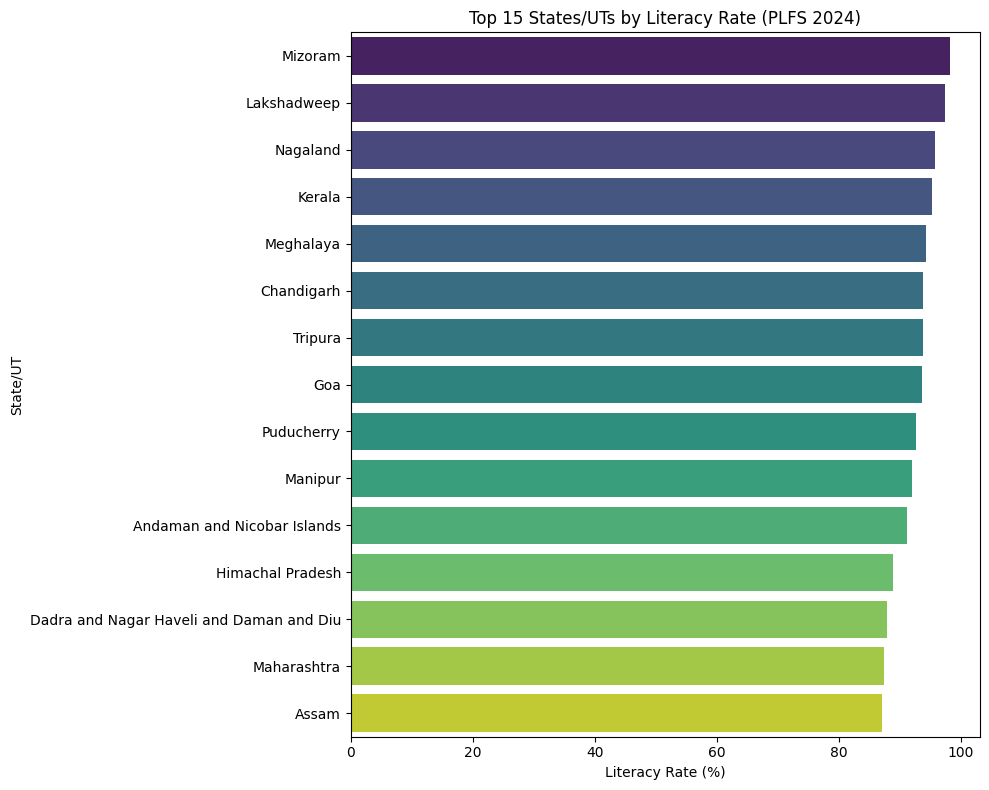

In [299]:
# Load the cleaned literacy dataset
final_df = pd.read_csv("Literacy_Rate.csv")

# Convert literacy rate columns to numeric (in case they were saved as strings)
for col in final_df.columns:
    if "Literacy rate" in col:
        final_df[col] = pd.to_numeric(final_df[col], errors="coerce")

# Get the top 15 states/UTs by total literacy rate (PLFS 2024)
top_states = final_df.nlargest(15, "Literacy rate (PLFS 2024) (Total)")

# Create a horizontal bar plot
plt.figure(figsize=(10, 8))
sns.barplot(
    x="Literacy rate (PLFS 2024) (Total)",
    y="State/UT",
    data=top_states,
    palette="viridis",
    hue="State/UT",
    legend=False
)

plt.title("Top 15 States/UTs by Literacy Rate (PLFS 2024)")
plt.xlabel("Literacy Rate (%)")
plt.ylabel("State/UT")
plt.tight_layout()
plt.show()


In [300]:
# Get and display the shape of the DataFrame (rows, columns)
df.shape

(38, 10)

In [301]:
# Display the column names of the DataFrame
df.columns

Index(['State/UT', 'Literacy rate (2011 Census) (Total)',
       'Literacy rate (2011 Census) (Male)',
       'Literacy rate (2011 Census) (Female)',
       'Literacy rate (NSC survey 2017) (Total)',
       'Literacy rate (NSC survey 2017) (Male)',
       'Literacy rate (NSC survey 2017) (Female)',
       'Literacy rate (PLFS 2024) (Total)', 'Literacy rate (PLFS 2024) (Male)',
       'Literacy rate (PLFS 2024) (Female)'],
      dtype='object')

In [302]:
# Generate and display descriptive statistics for the DataFrame
df.describe()

,Literacy rate (2011 Census) (Total),Literacy rate (NSC survey 2017) (Total),Literacy rate (PLFS 2024) (Total)
count,35.000000,36.000000,36.000000
mean,77.858000,81.233333,85.605556
std,8.592702,7.646019,7.116819
min,61.800000,66.950000,72.600000
25%,71.235000,76.770000,80.500000
50%,76.940000,81.350000,84.750000
75%,85.950000,86.562500,92.175000
max,94.000000,99.010000,98.200000


In [303]:
# Count and display the number of missing values per column
df.isnull().sum()

State/UT                                    0
Literacy rate (2011 Census) (Total)         3
Literacy rate (2011 Census) (Male)          0
Literacy rate (2011 Census) (Female)        0
Literacy rate (NSC survey 2017) (Total)     2
Literacy rate (NSC survey 2017) (Male)      0
Literacy rate (NSC survey 2017) (Female)    0
Literacy rate (PLFS 2024) (Total)           2
Literacy rate (PLFS 2024) (Male)            0
Literacy rate (PLFS 2024) (Female)          0
dtype: int64

In [304]:
# Display the data types of each column
df.dtypes

State/UT                                     object
Literacy rate (2011 Census) (Total)         float64
Literacy rate (2011 Census) (Male)           object
Literacy rate (2011 Census) (Female)         object
Literacy rate (NSC survey 2017) (Total)     float64
Literacy rate (NSC survey 2017) (Male)       object
Literacy rate (NSC survey 2017) (Female)     object
Literacy rate (PLFS 2024) (Total)           float64
Literacy rate (PLFS 2024) (Male)             object
Literacy rate (PLFS 2024) (Female)           object
dtype: object

In [305]:
# Columns to convert
num_cols = [
    "Literacy rate (2011 Census) (Total)",
    "Literacy rate (2011 Census) (Male)",
    "Literacy rate (2011 Census) (Female)",
    "Literacy rate (NSC survey 2017) (Total)",
    "Literacy rate (NSC survey 2017) (Male)",
    "Literacy rate (NSC survey 2017) (Female)",
    "Literacy rate (PLFS 2024) (Total)",
    "Literacy rate (PLFS 2024) (Male)",
    "Literacy rate (PLFS 2024) (Female)",
]

for col in num_cols:
    # Replace non-numeric values with NaN and convert to float
    final_df[col] = pd.to_numeric(final_df[col].replace(["-", "Unknown"], pd.NA), errors='coerce')

# Check result
print(final_df.dtypes)
print(final_df.head())


State/UT                                     object
Literacy rate (2011 Census) (Total)         float64
Literacy rate (2011 Census) (Male)          float64
Literacy rate (2011 Census) (Female)        float64
Literacy rate (NSC survey 2017) (Total)     float64
Literacy rate (NSC survey 2017) (Male)      float64
Literacy rate (NSC survey 2017) (Female)    float64
Literacy rate (PLFS 2024) (Total)           float64
Literacy rate (PLFS 2024) (Male)            float64
Literacy rate (PLFS 2024) (Female)          float64
dtype: object
                      State/UT  Literacy rate (2011 Census) (Total)  \
0  Andaman and Nicobar Islands                                86.63   
1               Andhra Pradesh                                67.02   
2            Arunachal Pradesh                                65.38   
3                        Assam                                72.19   
4                        Bihar                                61.80   

   Literacy rate (2011 Census) (Male)  

In [306]:
# Set pandas display options to show full table (optional, can be slow for large data)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Display the full DataFrame
df

,State/UT,Literacy rate (2011 Census) (Total),Literacy rate (2011 Census) (Male),Literacy rate (2011 Census) (Female),Literacy rate (NSC survey 2017) (Total),Literacy rate (NSC survey 2017) (Male),Literacy rate (NSC survey 2017) (Female),Literacy rate (PLFS 2024) (Total),Literacy rate (PLFS 2024) (Male),Literacy rate (PLFS 2024) (Female)
0,Andaman and Nicobar Islands,86.63,90.27,82.43,86.27,90.11,81.84,91.1,95.0,87.0
1,Andhra Pradesh,67.02,74.88,59.15,67.40,80.0,59.5,72.6,78.8,66.8
2,Arunachal Pradesh,65.38,72.55,57.70,66.95,73.4,59.50,84.2,88.0,80.3
3,Assam,72.19,77.85,66.27,85.90,90.1,81.2,87.0,90.3,83.6
4,Bihar,61.80,71.20,51.50,69.70,84.91,73.91,74.3,82.3,66.1
5,Chhattisgarh,70.28,80.27,60.24,77.30,85.4,68.8,78.5,86.2,70.6
6,Chandigarh,86.05,89.99,81.19,86.43,90.54,81.38,93.7,96.4,90.7
7,Dadra and Nagar Haveli,76.34,85.17,64.32,77.65,86.46,77.65,NaN,-,-
8,Daman and Diu,87.10,91.54,79.55,87.07,91.48,87.07,NaN,-,-
9,Dadra and Nagar Haveli and Daman and Diu,NaN,-,-,NaN,-,-,87.8,93.6,80.7


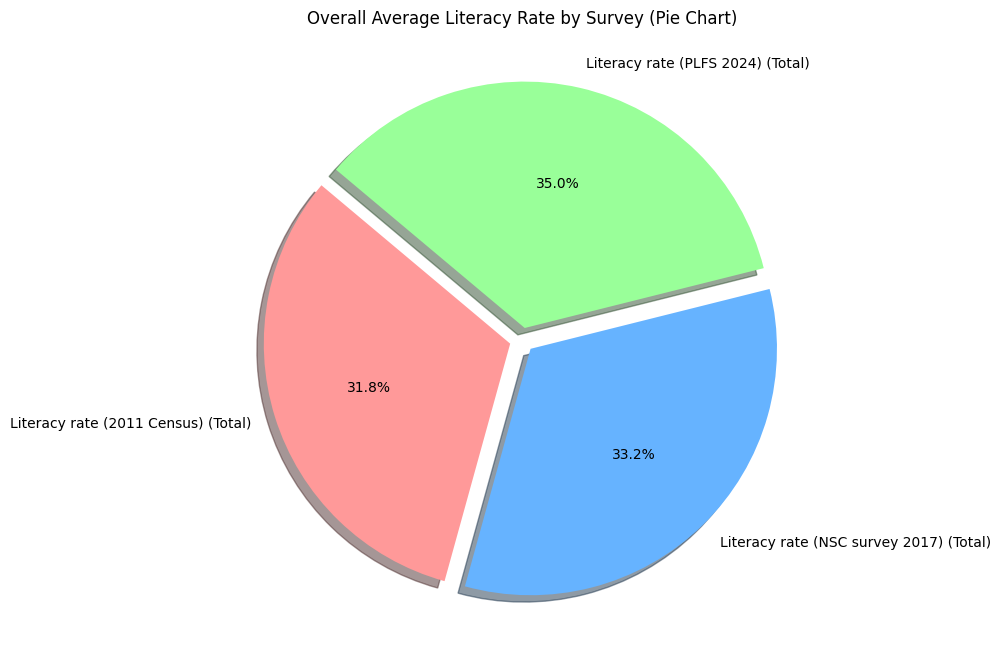

In [307]:
# 1. Overall literacy rate by survey
# Calculate overall average literacy rates
overall_avg = final_df[[
    "Literacy rate (2011 Census) (Total)",
    "Literacy rate (NSC survey 2017) (Total)",
    "Literacy rate (PLFS 2024) (Total)"
]].mean()

# Pie chart
colors = ['#ff9999','#66b3ff','#99ff99']  # Optional custom colors
explode = (0.05, 0.05, 0.05)  # Slightly "explode" all slices for emphasis

plt.figure(figsize=(8,8))
plt.pie(overall_avg, labels=overall_avg.index, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, shadow=True)
plt.title("Overall Average Literacy Rate by Survey (Pie Chart)")
plt.show()

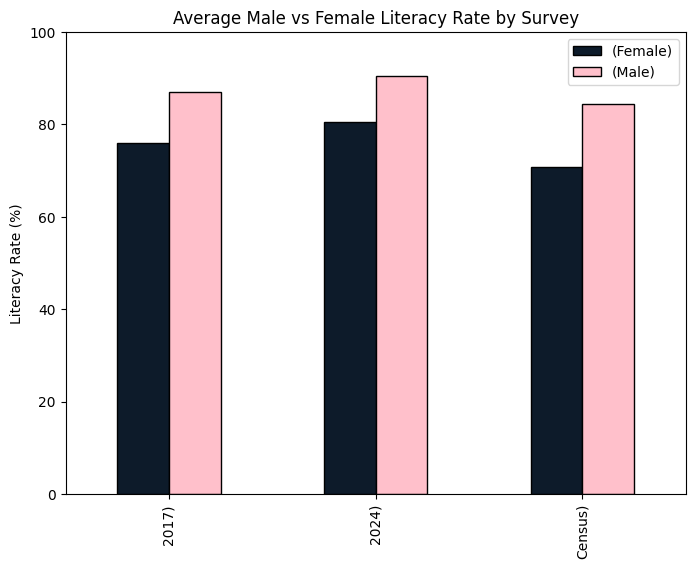

In [308]:
# 2. Male vs Female literacy rate (overall)
# Calculate averages
male_female_avg = final_df[[
    "Literacy rate (2011 Census) (Male)", "Literacy rate (2011 Census) (Female)",
    "Literacy rate (NSC survey 2017) (Male)", "Literacy rate (NSC survey 2017) (Female)",
    "Literacy rate (PLFS 2024) (Male)", "Literacy rate (PLFS 2024) (Female)"
]].mean()

# Reshape for plotting
male_female_avg.index = pd.MultiIndex.from_tuples([tuple(i.split()[-2:]) for i in male_female_avg.index])
male_female_avg = male_female_avg.unstack()

# Plot
male_female_avg.plot(kind='bar', figsize=(8,6), color=['#0D1B2A','#FFC0CB'], edgecolor='black')
plt.ylabel('Literacy Rate (%)')
plt.title('Average Male vs Female Literacy Rate by Survey')
plt.ylim(0,100)
plt.show()

7. # 📊 Bottom 5 States/UTs Literacy Rate Comparison by Year (2011, 2017, 2024)

This script loads literacy rate data from a CSV file and generates lollipop charts for the bottom 5 states/UTs by literacy rate for three different years (2011, 2017, and 2024).

Each year is color-coded for easy comparison.

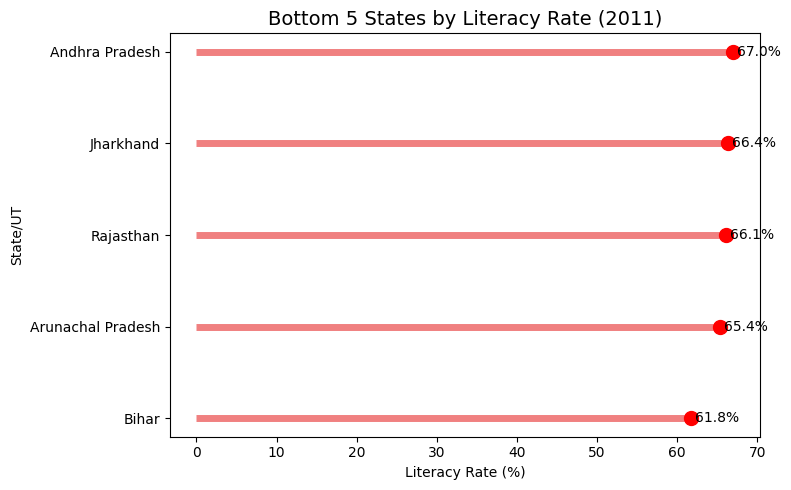

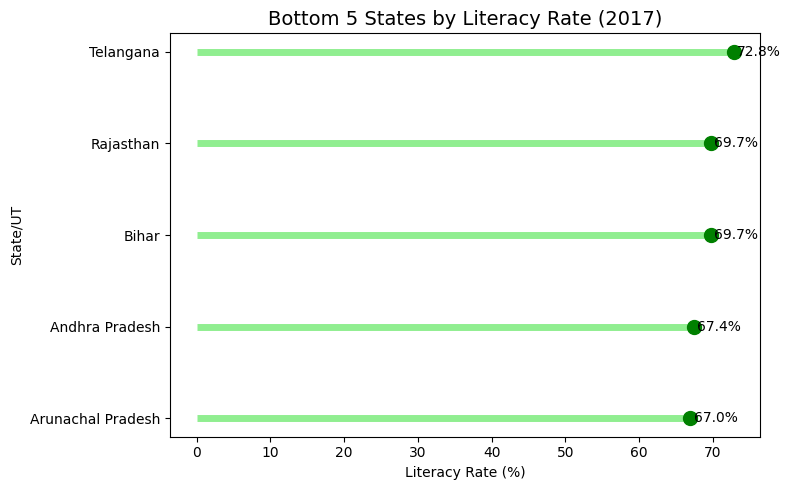

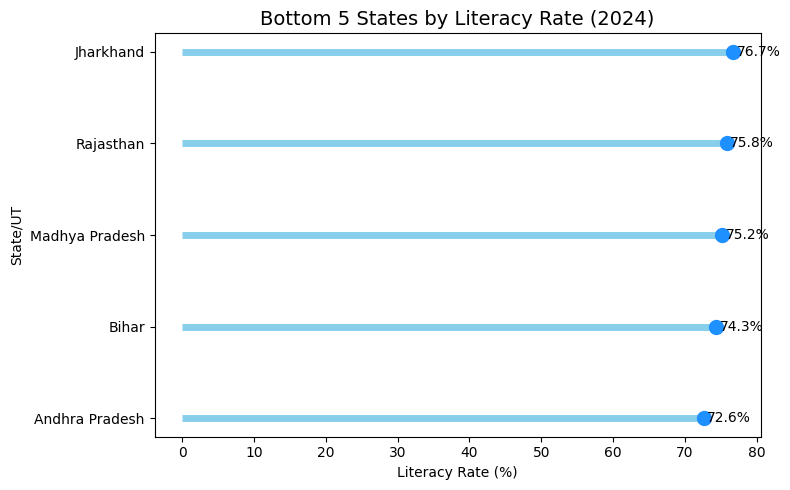

In [309]:
# Load dataset
df = pd.read_csv("Literacy_Rate.csv")

# Columns and corresponding colors
cols_colors = {
    "Literacy rate (2011 Census) (Total)": ("lightcoral", "red", "2011"),
    "Literacy rate (NSC survey 2017) (Total)": ("lightgreen", "green", "2017"),
    "Literacy rate (PLFS 2024) (Total)": ("skyblue", "dodgerblue", "2024")
}

# Convert literacy columns to numeric
df[list(cols_colors.keys())] = df[list(cols_colors.keys())].apply(pd.to_numeric, errors='coerce')

# Function to plot bottom 5 lollipop chart
def plot_bottom5(column, line_color, dot_color, year):
    bottom5 = df[['State/UT', column]].nsmallest(5, column)
    plt.figure(figsize=(8,5))
    plt.hlines(y=bottom5['State/UT'], xmin=0, xmax=bottom5[column], color=line_color, linewidth=5)
    plt.plot(bottom5[column], bottom5['State/UT'], "o", color=dot_color, markersize=10)
    for i, val in enumerate(bottom5[column]):
        plt.text(val + 0.5, i, f"{val:.1f}%", va='center')
    plt.title(f'Bottom 5 States by Literacy Rate ({year})', fontsize=14)
    plt.xlabel('Literacy Rate (%)')
    plt.ylabel('State/UT')
    plt.tight_layout()
    plt.show()

# Plot all three charts
for col, (line_color, dot_color, year) in cols_colors.items():
    plot_bottom5(col, line_color, dot_color, year)


# 4. 👩‍🎓 Gender Gap in Literacy Rate (2024)

This visualization highlights the **difference in literacy rates between males and females** across Indian states and union territories for the year **2024 (PLFS data)**.  
A larger value indicates a **wider gender gap**, meaning males have significantly higher literacy rates than females.


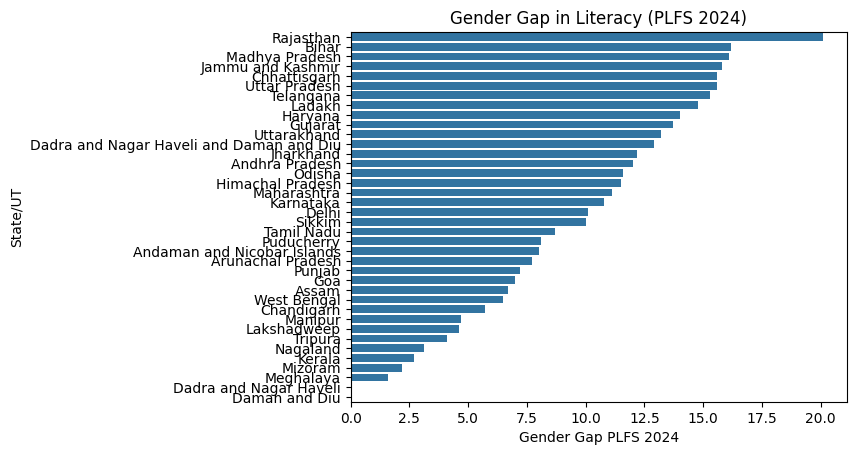

In [310]:
# 5. Gender gap per state (2024)
final_df['Gender Gap PLFS 2024'] = final_df['Literacy rate (PLFS 2024) (Male)'] - final_df['Literacy rate (PLFS 2024) (Female)']
sns.barplot(data=final_df.sort_values('Gender Gap PLFS 2024', ascending=False), x='Gender Gap PLFS 2024', y='State/UT')
plt.title('Gender Gap in Literacy (PLFS 2024)')
plt.show()

5. # 📈 Improvement in Total Literacy Rate (2011 vs 2024)

This chart shows the **distribution of literacy rate improvement** across all states/UTs between 2011 and 2024 using a histogram with a KDE line. It highlights which states improved the most over time.


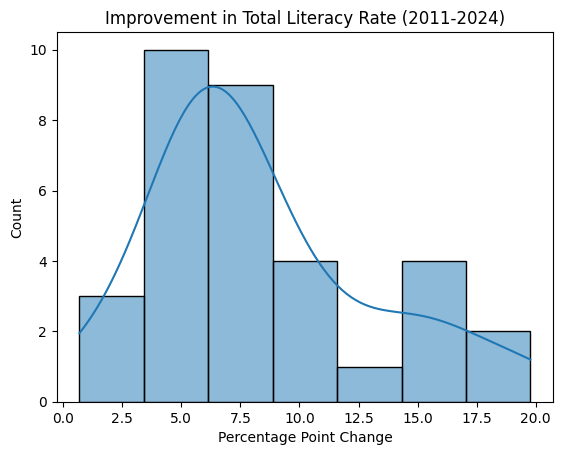

In [311]:
#  Histogram of Improvement over time (Total literacy)
final_df['Improvement 2011-2024'] = final_df['Literacy rate (PLFS 2024) (Total)'] - final_df['Literacy rate (2011 Census) (Total)']
sns.histplot(final_df['Improvement 2011-2024'].dropna(), kde=True)
plt.title('Improvement in Total Literacy Rate (2011-2024)')
plt.xlabel('Percentage Point Change')
plt.show()

6. # 📊 Top 10 States by Literacy Improvement (2011–2024). 

This code identifies the ten states/UTs with the largest increase in literacy rates from 2011 to 2024 and visualises them using a horizontal bar chart.  

📈 Top 10 States by Literacy Improvement (2011-2024):
         State/UT  Improvement 2011-2024
        Meghalaya                  19.77
Arunachal Pradesh                  18.82
         Nagaland                  16.15
          Manipur                  15.06
Jammu and Kashmir                  14.84
            Assam                  14.81
            Bihar                  12.50
    Uttar Pradesh                  10.52
        Jharkhand                  10.29
        Rajasthan                   9.69


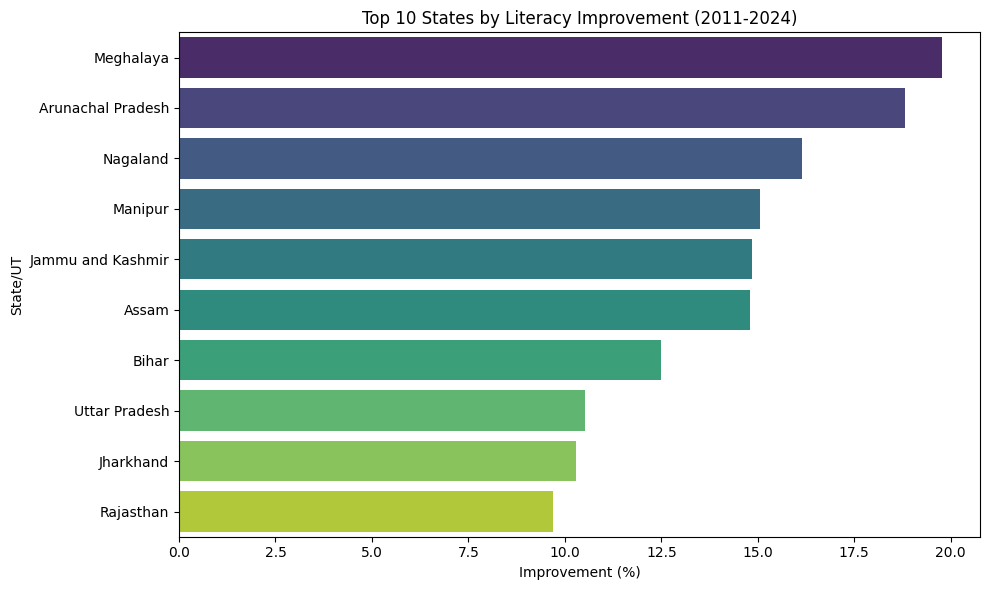

In [312]:
# --- Load the data ---

# Ensure improvement column is numeric
final_df['Improvement 2011-2024'] = pd.to_numeric(final_df['Improvement 2011-2024'], errors='coerce')

# Top 10 states
top_states = final_df.nlargest(10, 'Improvement 2011-2024')

# KPI summary
print("📈 Top 10 States by Literacy Improvement (2011-2024):")
print(top_states[['State/UT', 'Improvement 2011-2024']].to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_states,
    x='Improvement 2011-2024',
    y='State/UT',
    hue='State/UT',
    dodge=False,
    palette=sns.color_palette("viridis", 10),
    legend=False
)
plt.title('Top 10 States by Literacy Improvement (2011-2024)')
plt.xlabel('Improvement (%)')
plt.ylabel('State/UT')
plt.tight_layout()
plt.show()


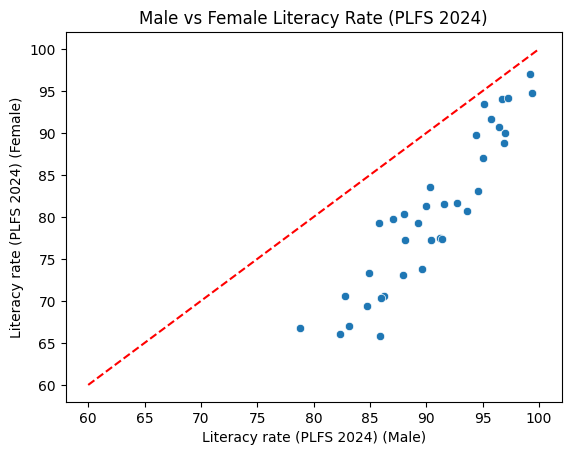

In [313]:
#  Correlation male vs female literacy (2024)
sns.scatterplot(data=final_df, x='Literacy rate (PLFS 2024) (Male)', y='Literacy rate (PLFS 2024) (Female)')
plt.plot([60,100],[60,100], 'r--')  # diagonal line
plt.title('Male vs Female Literacy Rate (PLFS 2024)')
plt.show()

# 3. 📉 Literacy Gender Gap Trend Over Time (2011–2024)

This chart shows how the **average gender gap in literacy** (difference between male and female literacy rates) has changed across three key surveys — **2011 Census**, **2017 NSC**, and **2024 PLFS**.  
A **downward trend** indicates progress toward reducing the literacy gap between genders.


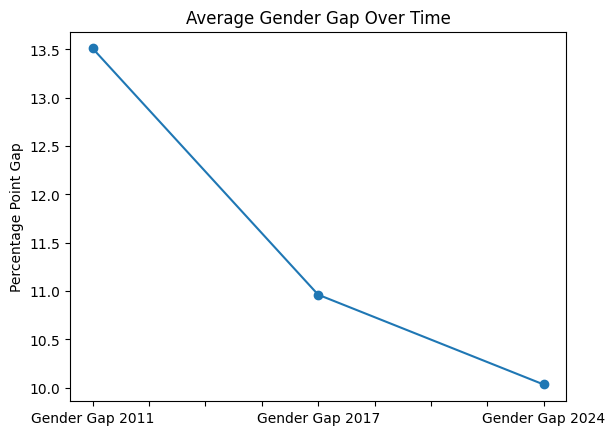

In [314]:
# 13. Literacy gap trend over surveys
final_df['Gender Gap 2011'] = final_df['Literacy rate (2011 Census) (Male)'] - final_df['Literacy rate (2011 Census) (Female)']
final_df['Gender Gap 2017'] = final_df['Literacy rate (NSC survey 2017) (Male)'] - final_df['Literacy rate (NSC survey 2017) (Female)']
final_df['Gender Gap 2024'] = final_df['Literacy rate (PLFS 2024) (Male)'] - final_df['Literacy rate (PLFS 2024) (Female)']
gender_gap_avg = final_df[['Gender Gap 2011','Gender Gap 2017','Gender Gap 2024']].mean()
gender_gap_avg.plot(kind='line', marker='o', title='Average Gender Gap Over Time')
plt.ylabel('Percentage Point Gap')
plt.show()

8. # 📊 Total Literacy Rate by State/UT (2011, 2017, 2024)

This plot shows the **total literacy rates** across Indian states/UTs for three surveys:
- **2011 Census**
- **NSC Survey 2017**
- **PLFS 2024**

The chart uses a **horizontal grouped bar chart** for readability, with a **custom color palette** for distinct years.


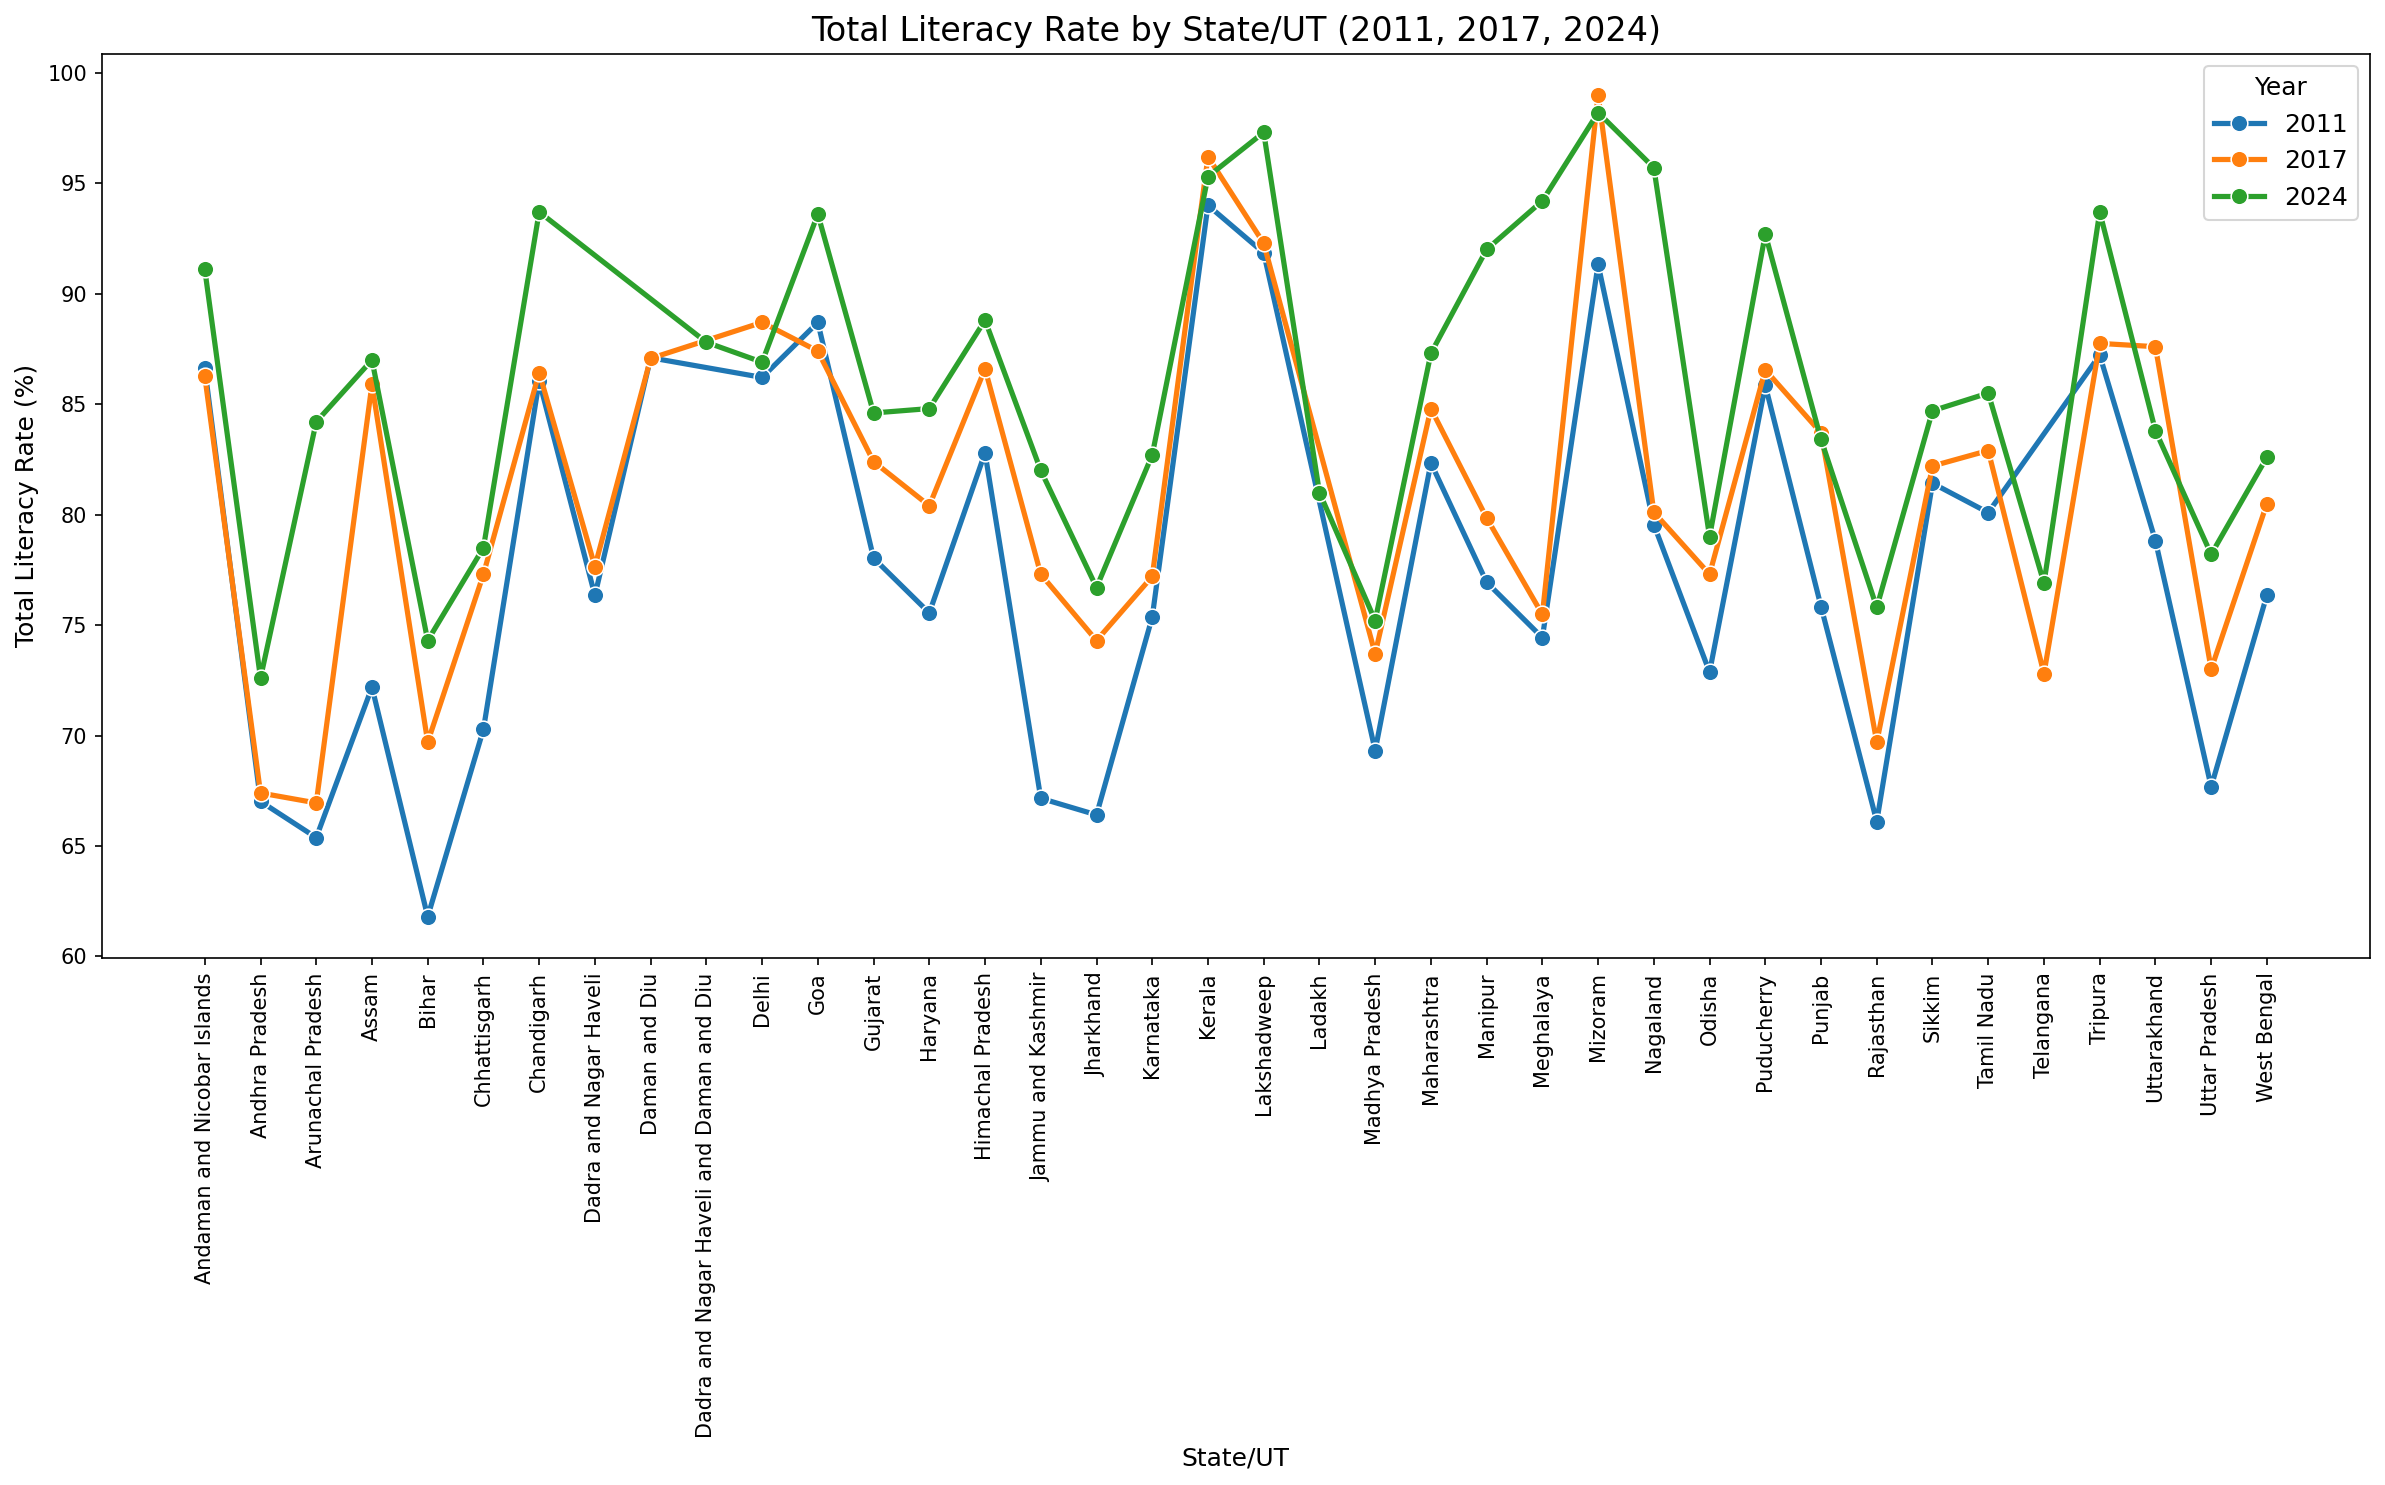

In [315]:
# Load dataset
df = pd.read_csv("Literacy_Rate.csv")
cols = ["Literacy rate (2011 Census) (Total)",
        "Literacy rate (NSC survey 2017) (Total)",
        "Literacy rate (PLFS 2024) (Total)"]
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Melt and simplify year labels
melted = df.melt(id_vars="State/UT", value_vars=cols,
                 var_name="Year", value_name="Total Literacy Rate")
melted["Year"] = melted["Year"].str.extract(r"(\d{4})")[0]

# Vibrant palette for interactive feel
palette = {"2011": "#1f77b4", "2017": "#ff7f0e", "2024": "#2ca02c"}  # Blue, Orange, Green

# Line plot
plt.figure(figsize=(16, 10), dpi=150)
sns.lineplot(data=melted, x="State/UT", y="Total Literacy Rate", hue="Year",
             marker="o", linewidth=2.5, markersize=8, palette=palette)
plt.title("Total Literacy Rate by State/UT (2011, 2017, 2024)", fontsize=16)
plt.xlabel("State/UT", fontsize=12)
plt.ylabel("Total Literacy Rate (%)", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.legend(loc='upper right', fontsize=12, title="Year", title_fontsize=12)  # Vertical legend
plt.show()


8. # 📈 Female Literacy Rate by State/UT (2011 vs 2017 vs 2024)

This plot shows the **female literacy rates** across Indian states/UTs for three surveys:
- **2011 Census**
- **NSC Survey 2017**
- **PLFS 2024**

The legend is displayed **below the state names** and slightly enlarged for better readability.


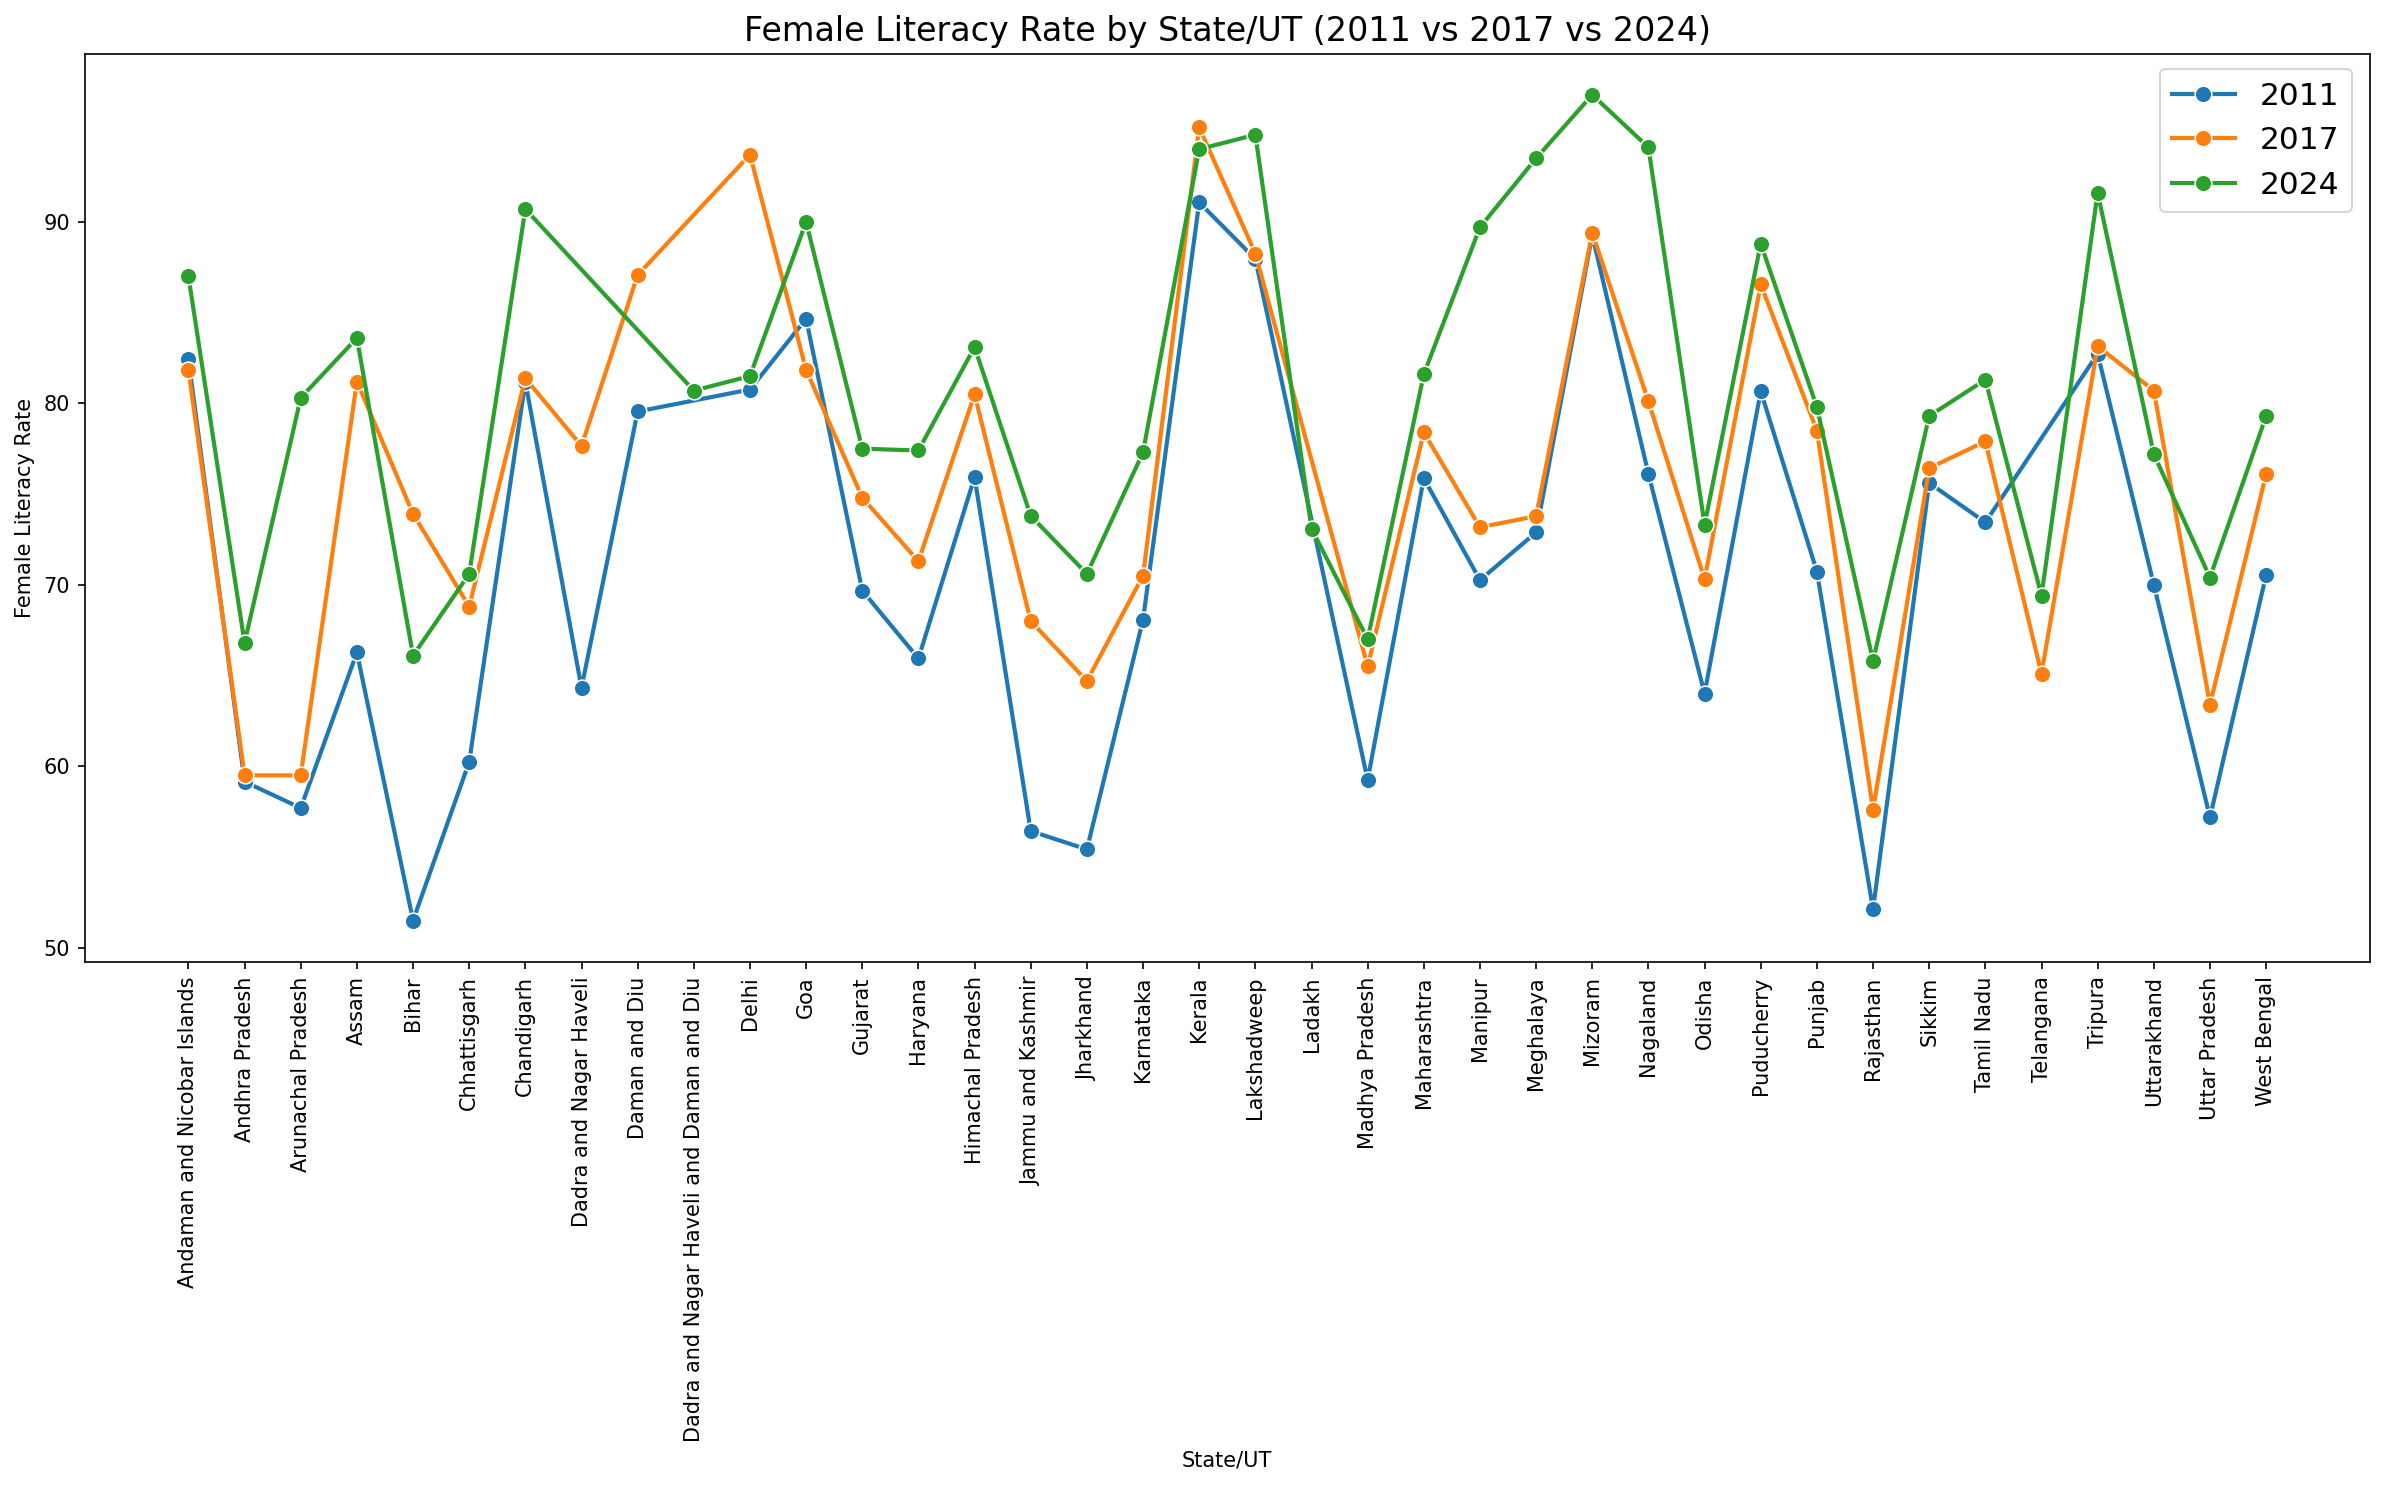

In [316]:
# Load dataset
df = pd.read_csv("Literacy_Rate.csv")
cols = ["Literacy rate (2011 Census) (Female)",
        "Literacy rate (NSC survey 2017) (Female)",
        "Literacy rate (PLFS 2024) (Female)"]
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Melt and extract year for clean legend
melted = df.melt(id_vars="State/UT", value_vars=cols,
                 var_name="Year", value_name="Female Literacy Rate")
melted["Year"] = melted["Year"].str.extract(r"(\d{4})")[0]

# Plot
plt.figure(figsize=(16, 10), dpi=150)
sns.lineplot(data=melted, x="State/UT", y="Female Literacy Rate",
             hue="Year", marker="o", linewidth=2, markersize=8)
plt.title("Female Literacy Rate by State/UT (2011 vs 2017 vs 2024)", fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.95, 1), fontsize=15)   # Legend below x-axis
plt.show()


8. # 📈 Male Literacy Rate by State/UT (2011 vs 2017 vs 2024)

This plot shows the **male literacy rates** across Indian states/UTs for three surveys:
- **2011 Census**
- **NSC Survey 2017**
- **PLFS 2024**

The legend is displayed **below the state names** and slightly enlarged for better readability.



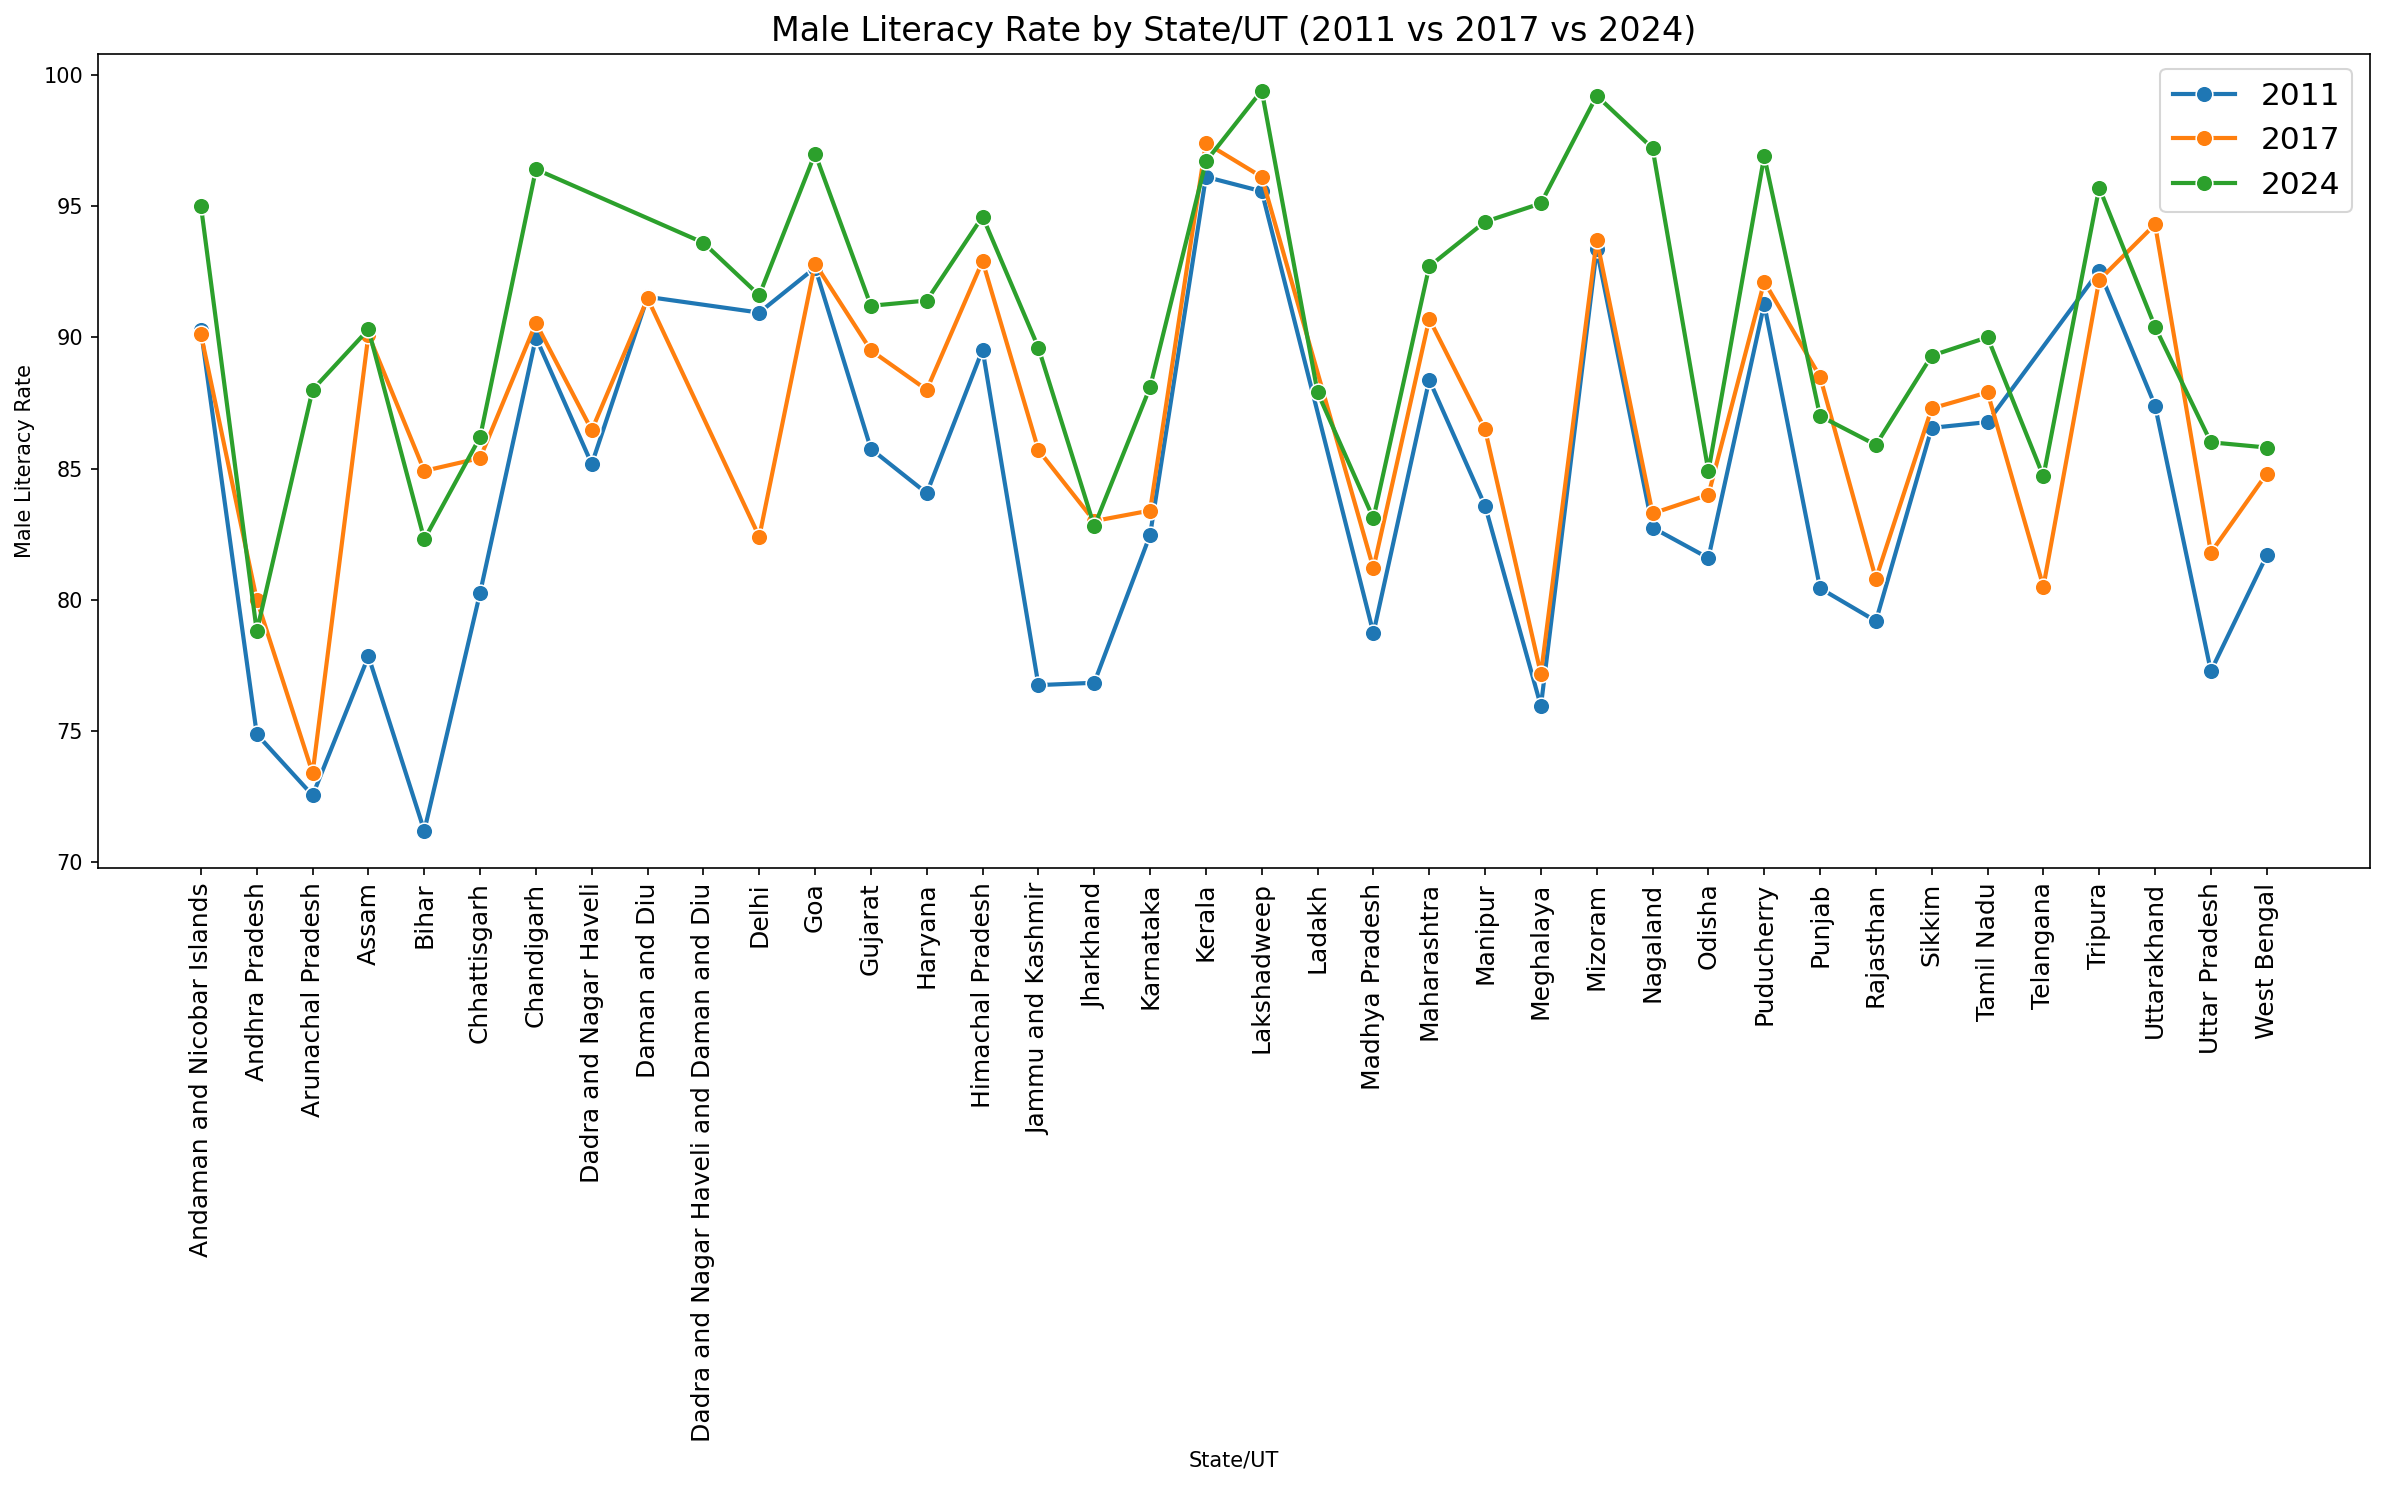

In [317]:
df = pd.read_csv("Literacy_Rate.csv")
cols = ["Literacy rate (2011 Census) (Male)",
        "Literacy rate (NSC survey 2017) (Male)",
        "Literacy rate (PLFS 2024) (Male)"]
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

melted = df.melt(id_vars="State/UT", value_vars=cols,
                 var_name="Year", value_name="Male Literacy Rate")
melted["Year"] = melted["Year"].str.extract(r"(\d{4})")[0]

plt.figure(figsize=(16, 10), dpi=150)  # Increased height for legend
sns.lineplot(data=melted, x="State/UT", y="Male Literacy Rate",
             hue="Year", marker="o", linewidth=2, markersize=8)
plt.title("Male Literacy Rate by State/UT (2011 vs 2017 vs 2024)", fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.95, 1), fontsize=15)  # Centered below x-axis
plt.show()


9. # 📊 Average Literacy Rate by Region (2011 vs 2017 vs 2024)

This chart shows the **average literacy rates** across different **regions of India** for three surveys:
- **2011 Census**
- **NSC Survey 2017**
- **PLFS 2024**

The chart uses a **grouped bar plot**

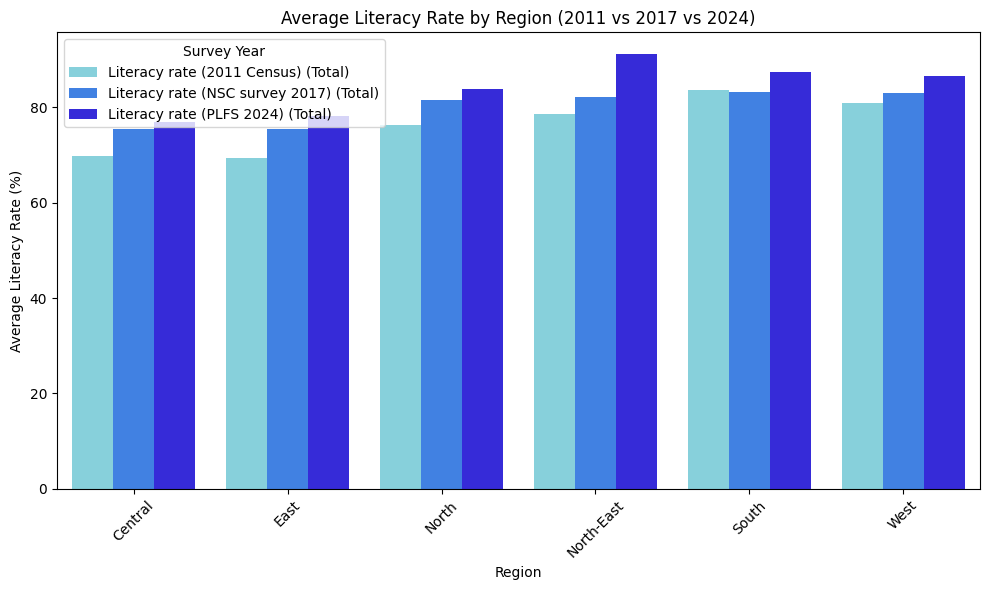

In [318]:
# --- Regional Mapping ---
REGION_MAP = {
    'Andaman and Nicobar Islands': 'South', 'Andhra Pradesh': 'South', 'Arunachal Pradesh': 'North-East',
    'Assam': 'North-East', 'Bihar': 'East', 'Chhattisgarh': 'Central', 'Delhi': 'North', 'Goa': 'South',
    'Gujarat': 'West', 'Haryana': 'North', 'Himachal Pradesh': 'North', 'Jammu and Kashmir': 'North',
    'Jharkhand': 'East', 'Karnataka': 'South', 'Kerala': 'South', 'Ladakh': 'North', 'Lakshadweep': 'South',
    'Madhya Pradesh': 'Central', 'Maharashtra': 'West', 'Manipur': 'North-East', 'Meghalaya': 'North-East',
    'Mizoram': 'North-East', 'Nagaland': 'North-East', 'Odisha': 'East', 'Puducherry': 'South',
    'Punjab': 'North', 'Rajasthan': 'North', 'Sikkim': 'North-East', 'Tamil Nadu': 'South',
    'Telangana': 'South', 'Tripura': 'North-East', 'Uttar Pradesh': 'North', 'Uttarakhand': 'North',
    'West Bengal': 'East', 'Chandigarh': 'North', 'Dadra and Nagar Haveli and Daman and Diu': 'West',
    'Daman and Diu': 'West', 'Dadra and Nagar Haveli': 'West'
}

# --- Load Dataset ---
df = pd.read_csv("Literacy_Rate.csv")
df['Region'] = df['State/UT'].map(REGION_MAP)

# Convert all literacy columns to numeric in one line
df[df.columns[df.columns.str.contains("Literacy rate")]] = df.filter(like="Literacy rate").apply(pd.to_numeric, errors='coerce')

# --- Prepare and plot in one chain ---
melted = (
    df.groupby('Region')[["Literacy rate (2011 Census) (Total)",
                          "Literacy rate (NSC survey 2017) (Total)",
                          "Literacy rate (PLFS 2024) (Total)"]]
      .mean()
      .reset_index()
      .melt(id_vars='Region', var_name='Year', value_name='Average Literacy Rate')
)

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='Region', y='Average Literacy Rate', hue='Year', palette=["#79DAE9", "#267CFD", "#1D0EF5"])
plt.title('Average Literacy Rate by Region (2011 vs 2017 vs 2024)')
plt.xlabel('Region')
plt.ylabel('Average Literacy Rate (%)')
plt.xticks(rotation=45)
plt.legend(title='Survey Year')
plt.tight_layout()
plt.savefig('Regional_Literacy_Comparison_2011_2017_2024.png', dpi=300)
plt.show()


In [319]:
# 14. 🗺️ Interactive Literacy Rate Map (Census 2011)

USER_AGENT = "IndiaLiteracyMapper/1.0"
df = pd.read_csv("Literacy_Rate.csv")

# Convert to numeric safely (remove '%' or text, handle '-' and 'Unknown')
df["Literacy rate (2011 Census) (Total)"] = pd.to_numeric(
    df["Literacy rate (2011 Census) (Total)"]
    .astype(str)
    .str.replace("%", "", regex=False),
    errors="coerce"
)

# Categorize literacy rates (2011)
bins = [0, 70, 75, 80, 85, 90, 100]
labels = ["<70%", "70-75%", "75-80%", "80-85%", "85-90%", ">90%"]
df["Literacy_Category_2011"] = pd.cut(df["Literacy rate (2011 Census) (Total)"], bins=bins, labels=labels)

# Geocoder setup
nominatim = Nominatim(user_agent=USER_AGENT, timeout=10)
photon = Photon(user_agent=USER_AGENT, timeout=10)
nominatim_geocode = RateLimiter(nominatim.geocode, min_delay_seconds=1, swallow_exceptions=True)
photon_geocode = RateLimiter(photon.geocode, min_delay_seconds=1, swallow_exceptions=True)
location_cache = {}

def geocode_state(name):
    if name in location_cache:
        return location_cache[name]
    location = nominatim_geocode(f"{name}, India") or photon_geocode(f"{name}, India")
    location_cache[name] = location
    return location

# Create base map
m = folium.Map(location=[22.9734, 78.6569], zoom_start=5, tiles="cartodbpositron")

# Color map
color_map = {
    "<70%": "#c6dbef",
    "70-75%": "#38d9f9",
    "75-80%": "#97e9e6",
    "80-85%": "#424faf",
    "85-90%": "#080a8e",
    ">90%": "#00441b"
}

# Add state markers
for _, row in df.iterrows():
    state = row["State/UT"]
    rate = row["Literacy rate (2011 Census) (Total)"]
    category = row["Literacy_Category_2011"]
    
    # Skip rows with missing rate or category
    if pd.isna(rate) or pd.isna(category):
        continue
    
    loc = geocode_state(state)
    if loc is None:
        continue
    
    folium.CircleMarker(
        location=[loc.latitude, loc.longitude],
        radius=8,
        color=color_map.get(category, "gray"),
        fill=True,
        fill_opacity=0.85,
        tooltip=f"<b>{state}</b><br>Literacy Rate: {rate:.1f}%<br>Category: {category}"
    ).add_to(m)

# Legend
legend_html = """
<div style="position: fixed; bottom: 50px; left: 50px; width: 170px; 
background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
padding: 10px; border-radius: 8px;">
<b>Literacy Rate (2011)</b><br>
<svg width="15" height="15"><rect width="15" height="15" style="fill:#00441b;"/></svg> >90%<br>
<svg width="15" height="15"><rect width="15" height="15" style="fill:#08519c;"/></svg> 85–90%<br>
<svg width="15" height="15"><rect width="15" height="15" style="fill:#3182bd;"/></svg> 80–85%<br>
<svg width="15" height="15"><rect width="15" height="15" style="fill:#6baed6;"/></svg> 75–80%<br>
<svg width="15" height="15"><rect width="15" height="15" style="fill:#9ecae1;"/></svg> 70–75%<br>
<svg width="15" height="15"><rect width="15" height="15" style="fill:#c6dbef;"/></svg> <70%
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Save map
m.save("India_Literacy_Map_2011.html")
print("✅ Saved interactive map as India_Literacy_Map_2011.html")

✅ Saved interactive map as India_Literacy_Map_2011.html


10. # 📊 Top 5 States/UTs Literacy Rate Comparison by Year

This script generates **horizontal bar charts** showing the **Top 5 States/UTs** by literacy rate for each survey year:
- **2011 Census**
- **NSC Survey 2017**
- **PLFS 2024**

Each chart is saved as a PNG file.

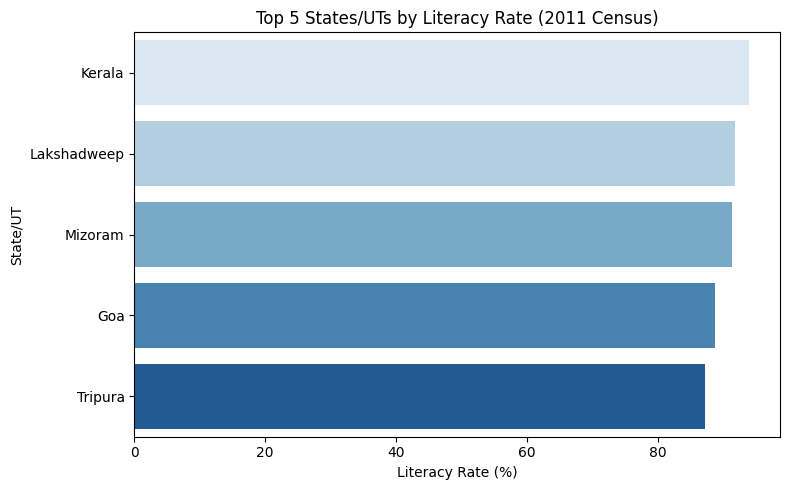

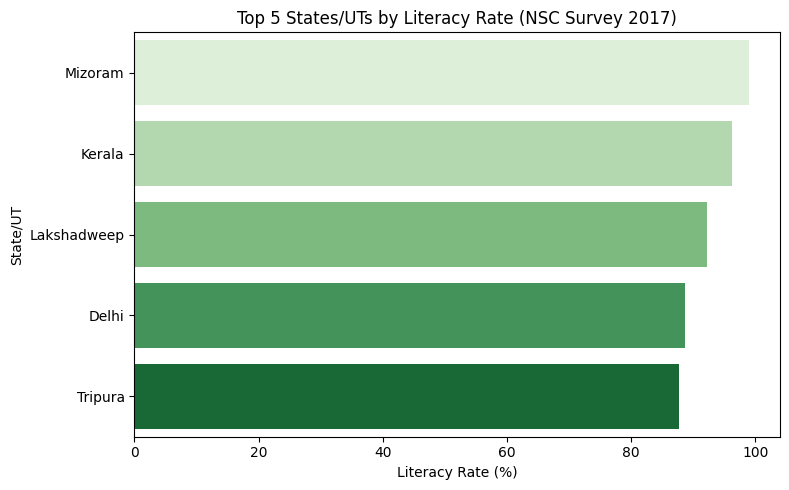

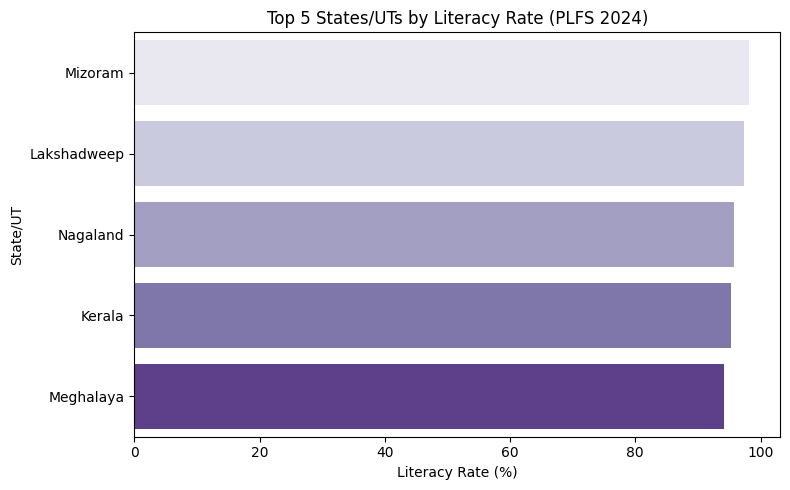

In [320]:
# Load the cleaned literacy dataset
final_df = pd.read_csv("Literacy_Rate.csv")

# Convert literacy rate columns to numeric
for col in final_df.columns:
    if "Literacy rate" in col:
        final_df[col] = pd.to_numeric(final_df[col], errors="coerce")

# --- 1️⃣ Top 5 by 2011 Census ---
top_2011 = final_df.nlargest(5, "Literacy rate (2011 Census) (Total)")

plt.figure(figsize=(8, 5))
sns.barplot(
    x="Literacy rate (2011 Census) (Total)",
    y="State/UT",
    data=top_2011,
    palette="Blues",
    hue="State/UT",
    legend=False
)
plt.title("Top 5 States/UTs by Literacy Rate (2011 Census)")
plt.xlabel("Literacy Rate (%)")
plt.ylabel("State/UT")
plt.tight_layout()
plt.savefig("Top5_Literacy_2011_Census.png", dpi=300)
plt.show()


# --- 2️⃣ Top 5 by NSC Survey 2017 ---
top_2017 = final_df.nlargest(5, "Literacy rate (NSC survey 2017) (Total)")

plt.figure(figsize=(8, 5))
sns.barplot(
    x="Literacy rate (NSC survey 2017) (Total)",
    y="State/UT",
    data=top_2017,
    palette="Greens",
    hue="State/UT",
    legend=False
)
plt.title("Top 5 States/UTs by Literacy Rate (NSC Survey 2017)")
plt.xlabel("Literacy Rate (%)")
plt.ylabel("State/UT")
plt.tight_layout()
plt.savefig("Top5_Literacy_NSC_2017.png", dpi=300)
plt.show()


# --- 3️⃣ Top 5 by PLFS 2024 ---
top_2024 = final_df.nlargest(5, "Literacy rate (PLFS 2024) (Total)")

plt.figure(figsize=(8, 5))
sns.barplot(
    x="Literacy rate (PLFS 2024) (Total)",
    y="State/UT",
    data=top_2024,
    palette="Purples",
    hue="State/UT",
    legend=False
)
plt.title("Top 5 States/UTs by Literacy Rate (PLFS 2024)")
plt.xlabel("Literacy Rate (%)")
plt.ylabel("State/UT")
plt.tight_layout()
plt.savefig("Top5_Literacy_PLFS_2024.png", dpi=300)
plt.show()
